# EDA on prepped data

In [1]:
# set up path to import my python scripts
import sys
import os
src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path+"/src")
    
%load_ext autoreload
%autoreload 2
import prep_data as prep
import main

In [2]:
# Establish required info
# link for data files
base_url = "http://kopiko.ifa.hawaii.edu/weather/archivedata/"

# Define reasonable ranges for each column
acceptable_ranges = {
    'temperature': (-273,40),
    'humidity': (0,100),
    'wind_speed': (0,100),
    'visibility': (0,100000),
    'precipitation': (0,100),
    'dewpoint': (-273,40)
    }
# Define the thresholds for ('Green', 'Red') weather - plan to use config file in future
thresholds = {
        'humidity': (75,85),
        'wind_sust': (10,12),
        'wind_gust': (15,15),
        'visibility': (50000,40000),
        'precipitation': (0,0),
        'dewpoint_delta': (6,3)
        }

In [3]:
# Run from jupyter
data_path_for_notebook = '../data/'
# get list of all data file urls
csv_urls = prep.get_csv_file_links(base_url)

# prep all data 
for url in csv_urls:
    year = url.split('/')[-1].split('.')[0]
    # for now skip 2020-2021 becuase I know the formating is not correct. Skip 1993 because it is empty.
    if year in ['1993','2020','2021']:
        continue
    # if prepped data file already exist for that year skip it
    elif main.prepped_data_exists(year,base_path=data_path_for_notebook):
        continue
    else:
        main.get_and_prep_data(url,acceptable_ranges,thresholds,save_results=True,save_path=data_path_for_notebook)

In [84]:
# combine the daily status hours for all years into one df
df = prep.combine_status_hour_dfs(base_path=data_path_for_notebook)
df = prep.normalize_daily_hours_to_24(df)
prep.add_month_year_columns(df)



Total rows          : 8965
-----------------------------
Number of NaNs per column:
Green               :  562
Yellow              : 1625
Red                 : 1717
month               :    0
year                :    0
None


In [85]:
df

,Green,Yellow,Red,month,year
date,,,,,
1994-09-11,21.600000,0.000000,2.400000,Sep,1994
1994-09-12,23.000000,0.000000,1.000000,Sep,1994
1994-09-13,22.500000,0.000000,1.500000,Sep,1994
1994-09-14,24.000000,0.000000,0.000000,Sep,1994
1994-09-15,23.741935,0.000000,0.258065,Sep,1994
...,...,...,...,...,...
2019-12-27,0.597499,0.054318,23.348183,Dec,2019
2019-12-28,4.137437,3.982820,15.879742,Dec,2019
2019-12-29,3.484241,5.154728,15.361032,Dec,2019


In [86]:

df.describe()

,Green,Yellow,Red,year
count,8965.000000,8965.000000,8965.000000,8965.000000
mean,12.864422,2.840526,8.295052,2006.789069
std,8.864368,2.882648,8.682301,7.277076
min,0.000000,0.000000,0.000000,1994.000000
25%,3.372034,0.424779,0.360042,2000.000000
50%,14.502931,2.289162,4.532742,2007.000000
75%,21.048263,4.027972,16.607295,2013.000000
max,24.000000,24.000000,24.000000,2019.000000


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8965 entries, 1994-09-11 to 2019-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Green   8965 non-null   float64 
 1   Yellow  8965 non-null   float64 
 2   Red     8965 non-null   float64 
 3   month   8965 non-null   category
 4   year    8965 non-null   int64   
dtypes: category(1), float64(3), int64(1)
memory usage: 359.3 KB


<br>

-------------------------------------


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size':16,'axes.labelcolor': '#000000','ytick.color': '#000000','xtick.color': '#000000'})

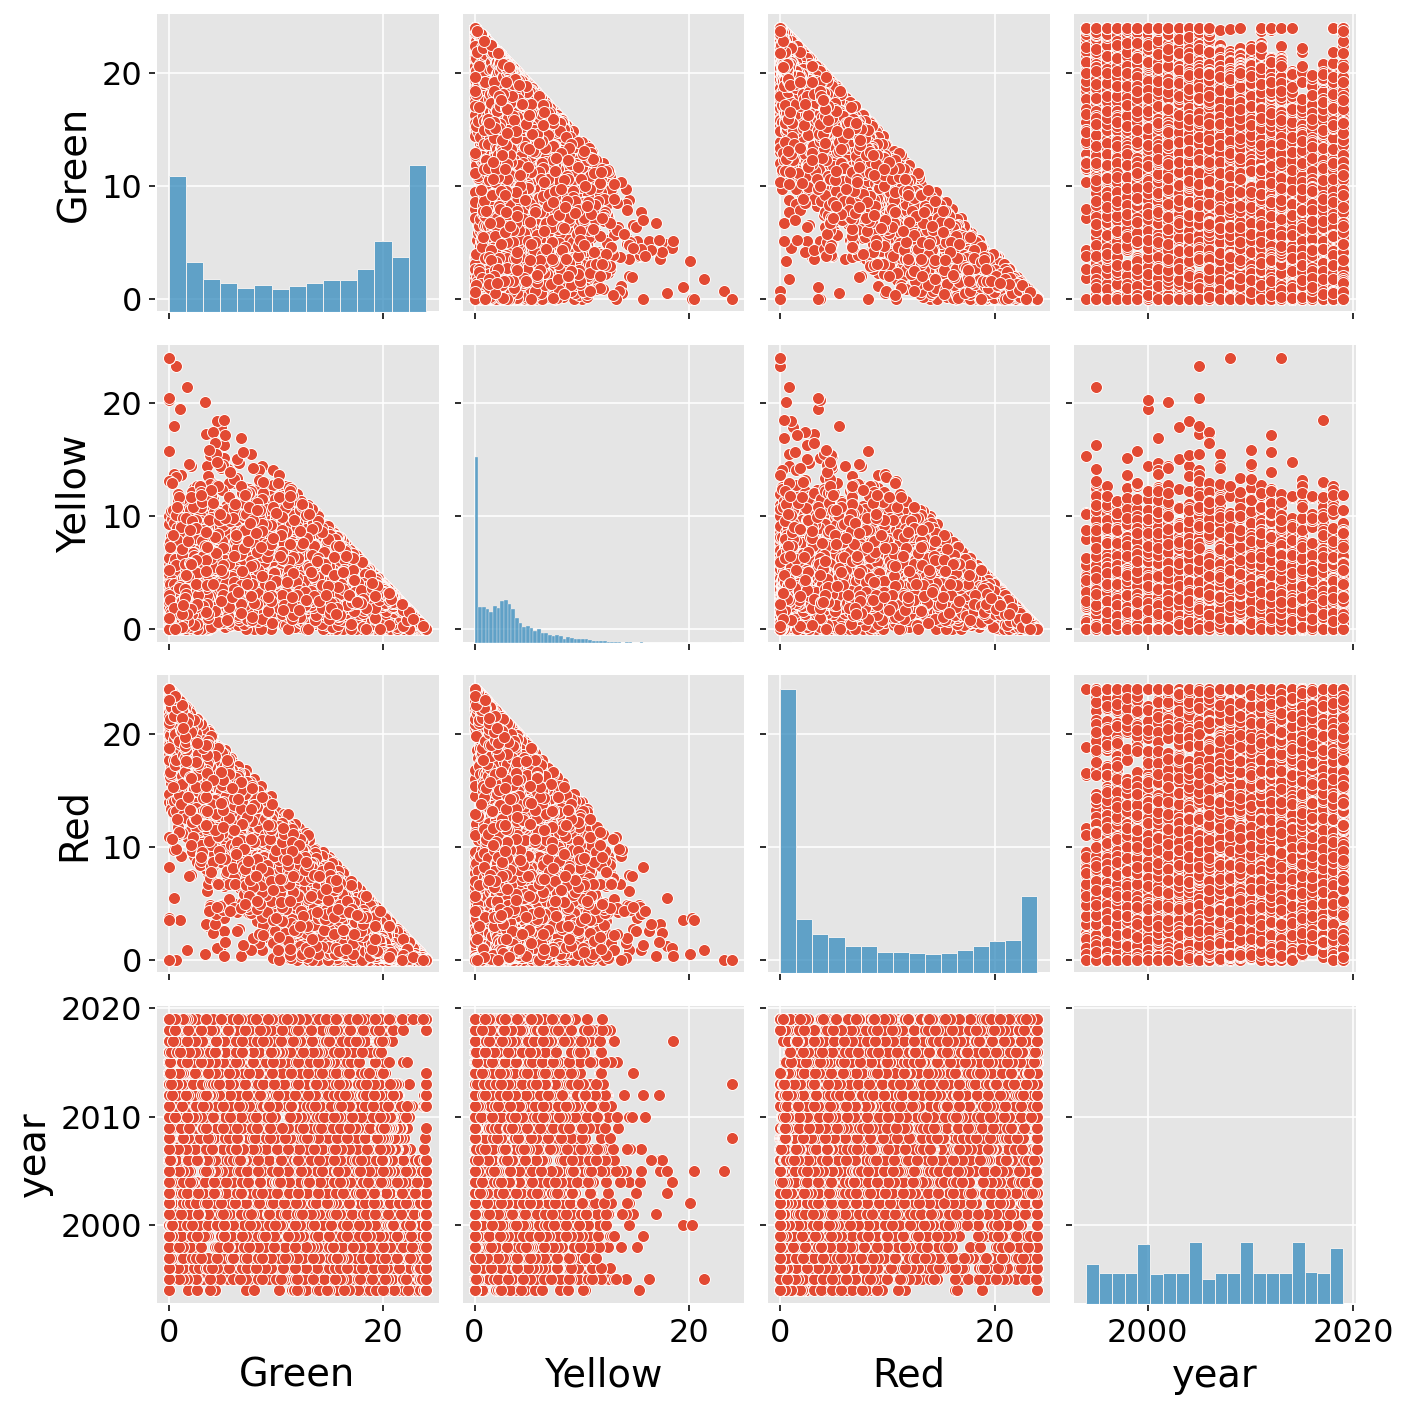

In [89]:
sns.pairplot(df)

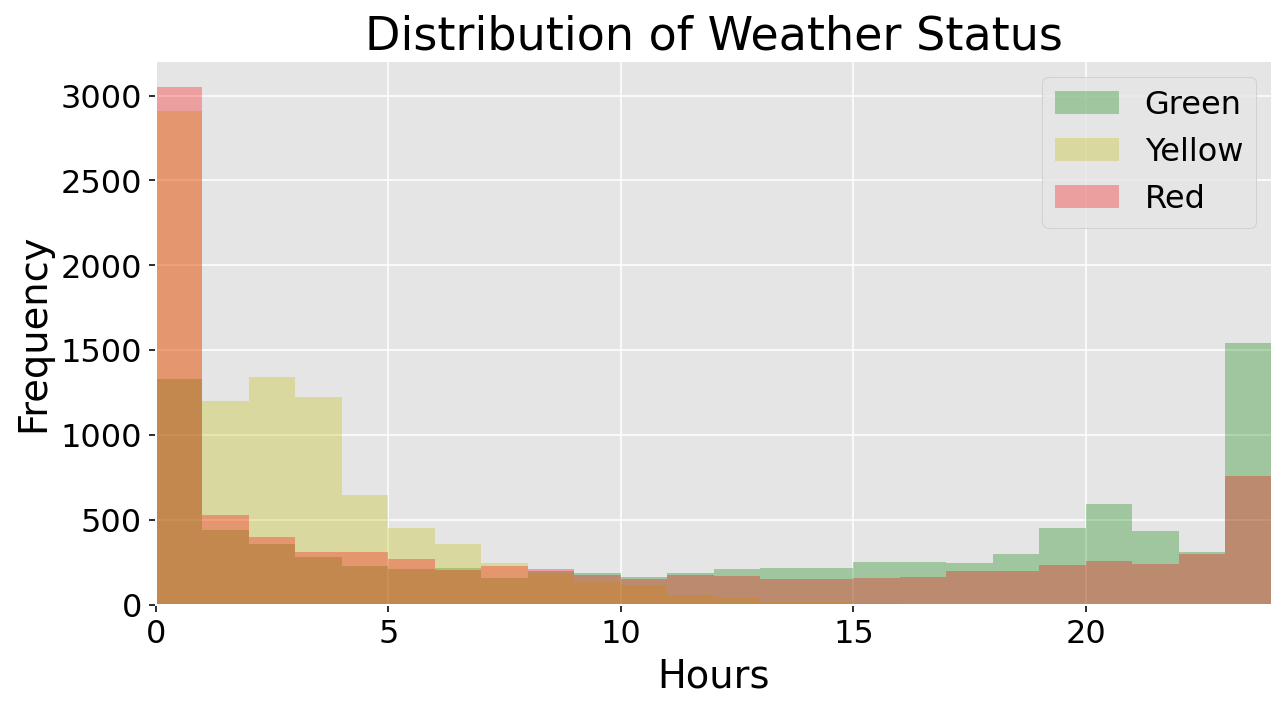

In [90]:
fig,ax = plt.subplots(figsize=(10,5))
df.Green.hist(bins=24,ax=ax,alpha=0.3,color='g',label='Green')
df.Yellow.hist(bins=24,ax=ax,alpha=0.3,color='y',label='Yellow')
df.Red.hist(bins=24,ax=ax,alpha=0.3,color='r',label='Red')
ax.set_xlim(0,24)
ax.set_xlabel('Hours')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Weather Status')
ax.legend();

In [91]:
# plt.rcParams

<AxesSubplot:xlabel='month'>

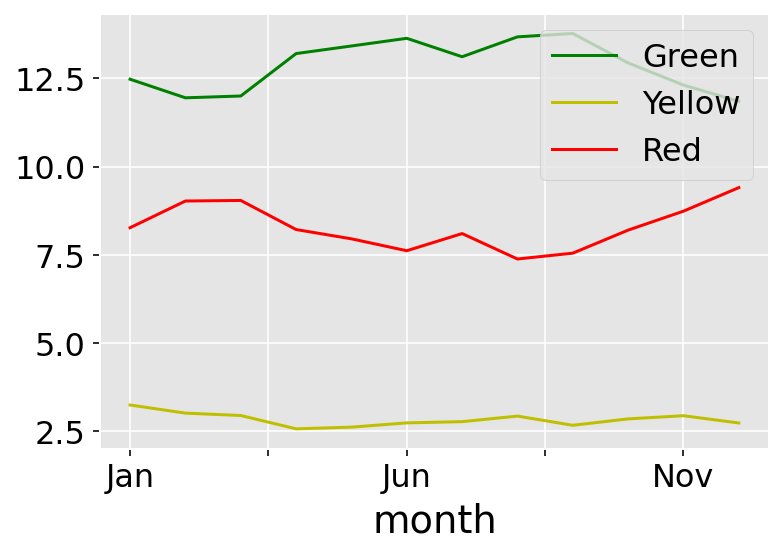

In [92]:
# Take a look at the mean for each month
df.drop('year',axis=1).groupby(['month']).mean().plot(color=['g','y','r'])


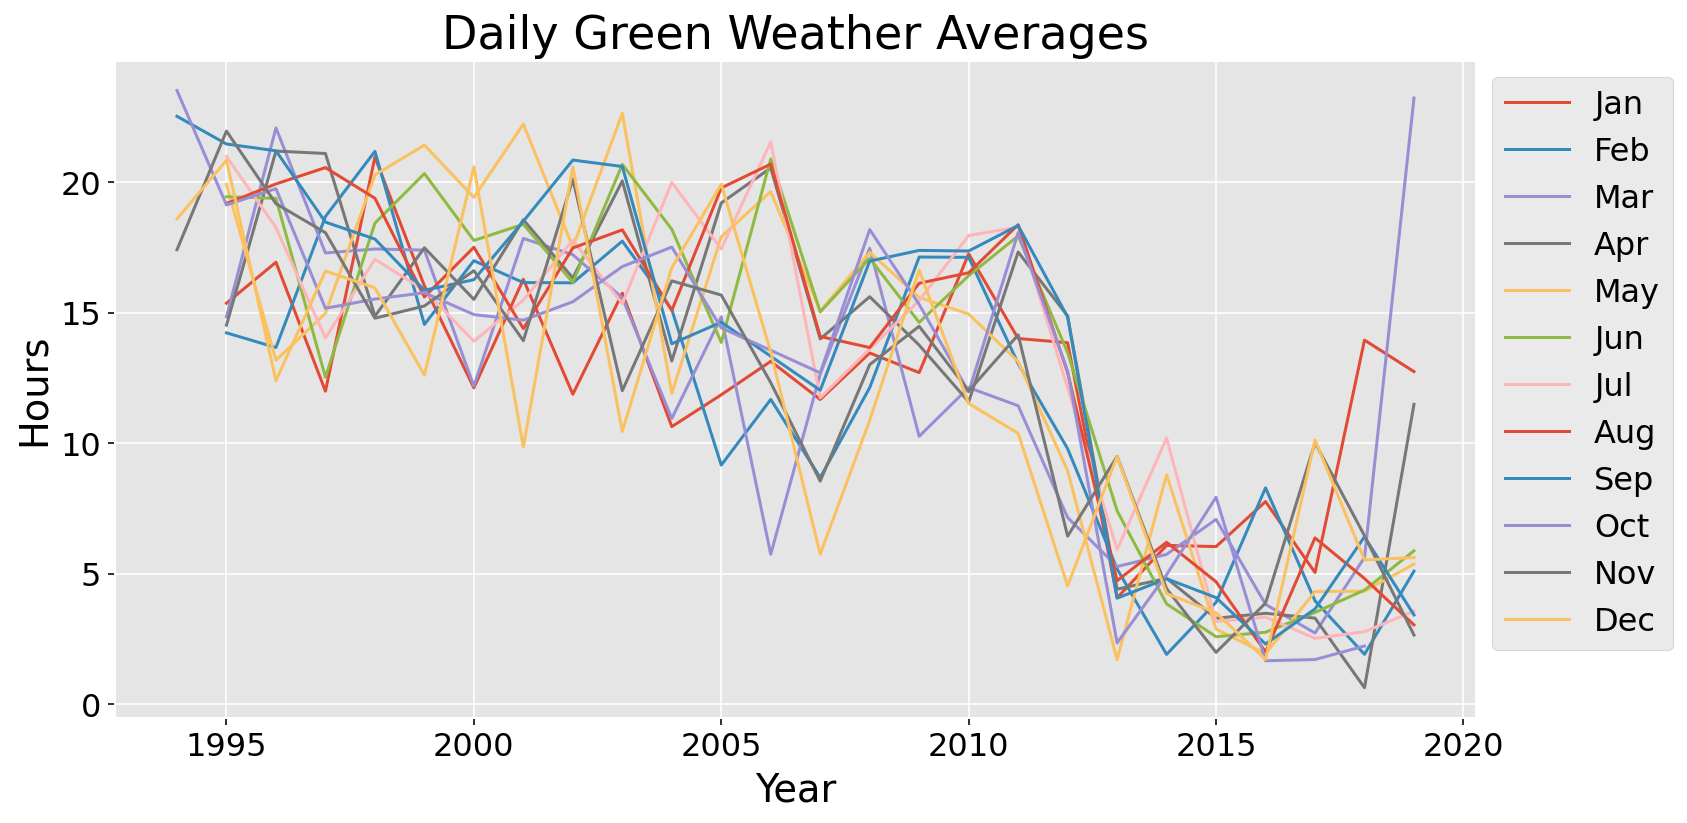

In [93]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig,ax = plt.subplots(figsize=(12,6))
for month in months:
    df[df['month']==month].groupby('year')['Green'].mean().plot(ax=ax,label=month)

ax.set_xlabel('Year')
ax.set_ylabel('Hours')
ax.set_title('Daily Green Weather Averages')
ax.legend(bbox_to_anchor=(1,1))
fig.tight_layout()

In [94]:
for month in sorted(df.month.unique()):
    print(f'{month}: {len(df[df.month==month])}')

Apr: 745
Aug: 743
Dec: 780
Feb: 683
Jan: 765
Jul: 773
Jun: 747
Mar: 747
May: 773
Nov: 756
Oct: 729
Sep: 724


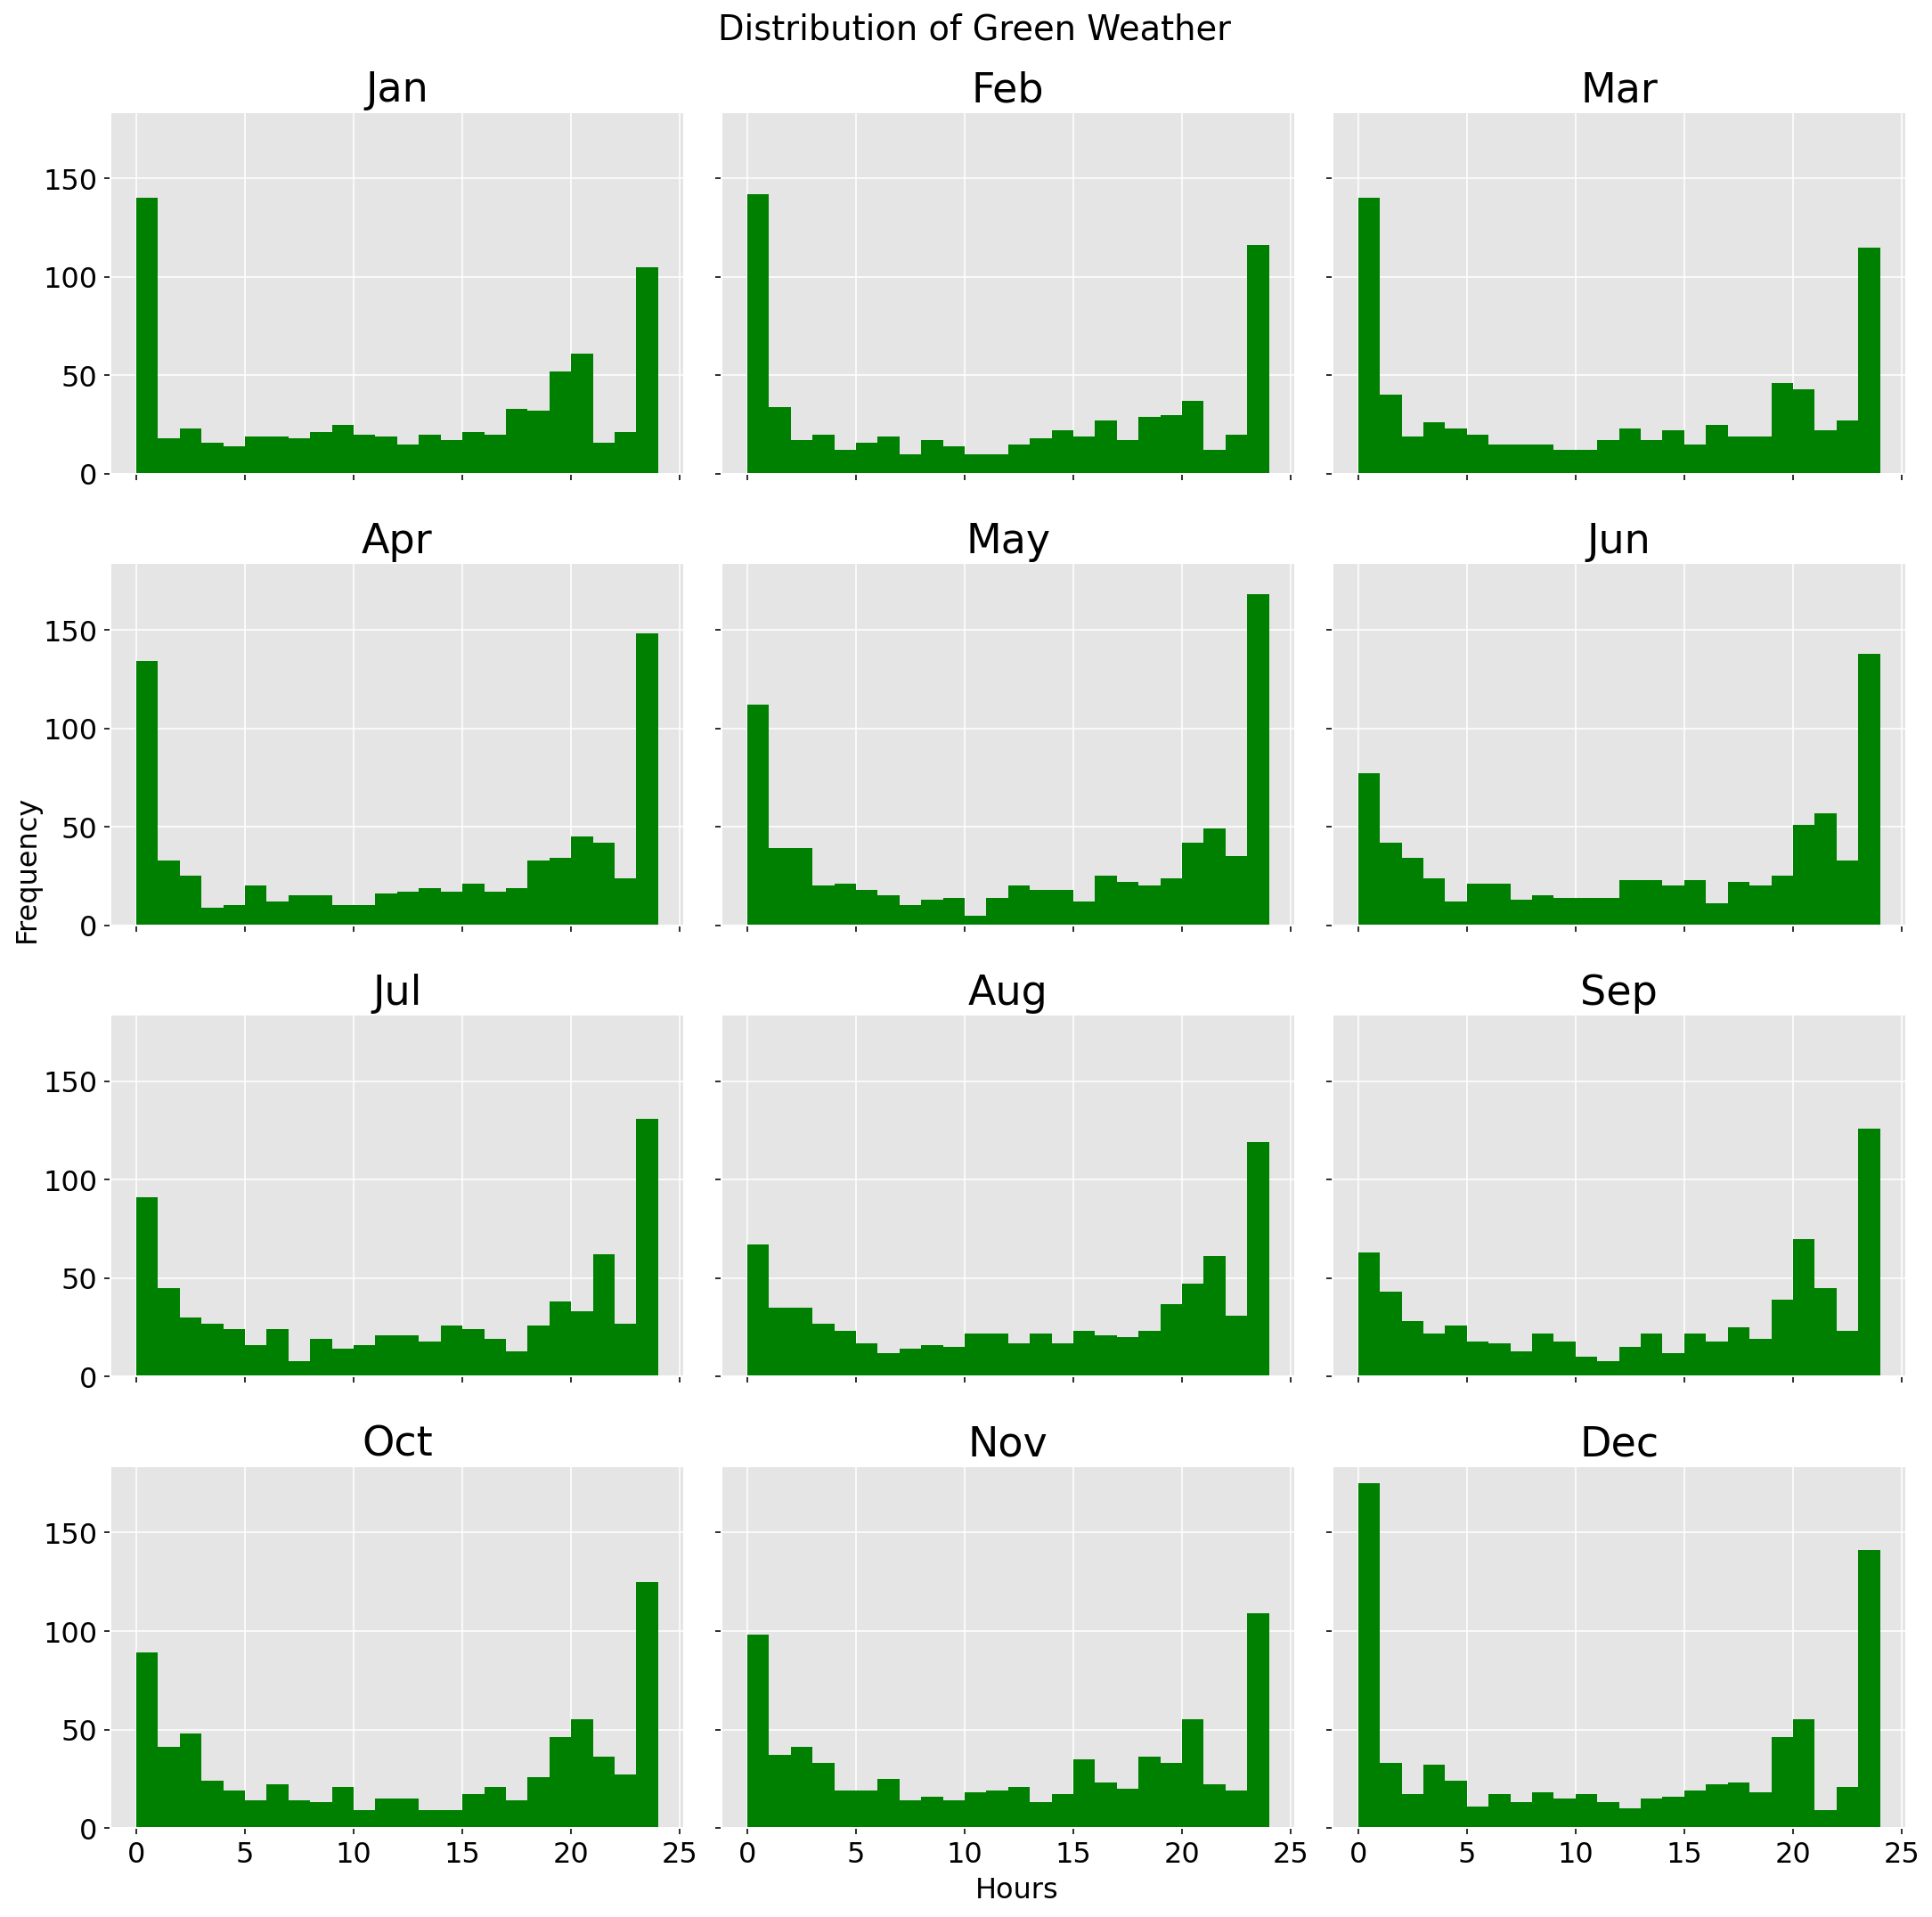

In [97]:
fig,axs = plt.subplots(4,3,figsize=(15,15),sharex=True,sharey=True)
for i,ax in enumerate(axs.flatten()):
    df[df['month']==months[i]].hist('Green',ax=ax,color='g',bins=24)
    ax.set_title(months[i])
fig.suptitle('Distribution of Green Weather')
fig.text(.5,0,'Hours')
fig.text(0,0.5,'Frequency',rotation='vertical')
fig.tight_layout();


All the distributions look similar, and definetely not normal. Plan to use Mann-Whitney U test.

array([[<AxesSubplot:title={'center':'Green'}>]], dtype=object)

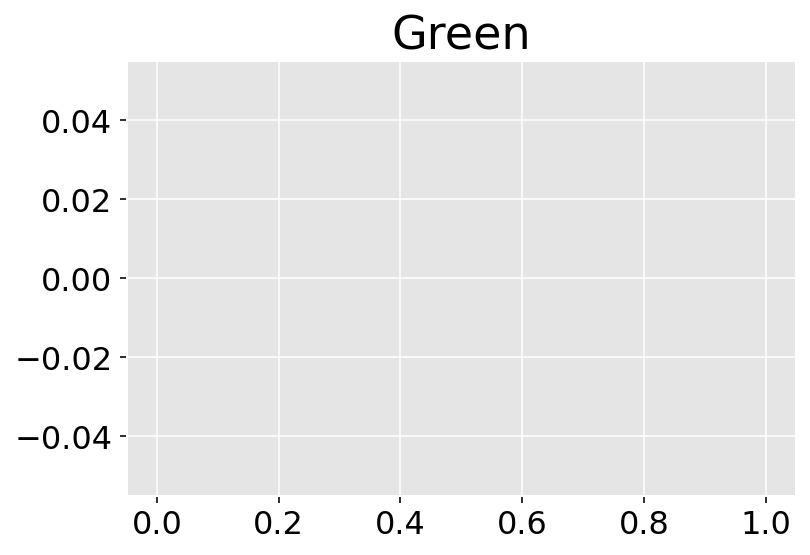

In [103]:
df[(df['month']=='Jun') & (df['year']==str(yrs[1]))].hist('Green',color='g',bins=24)

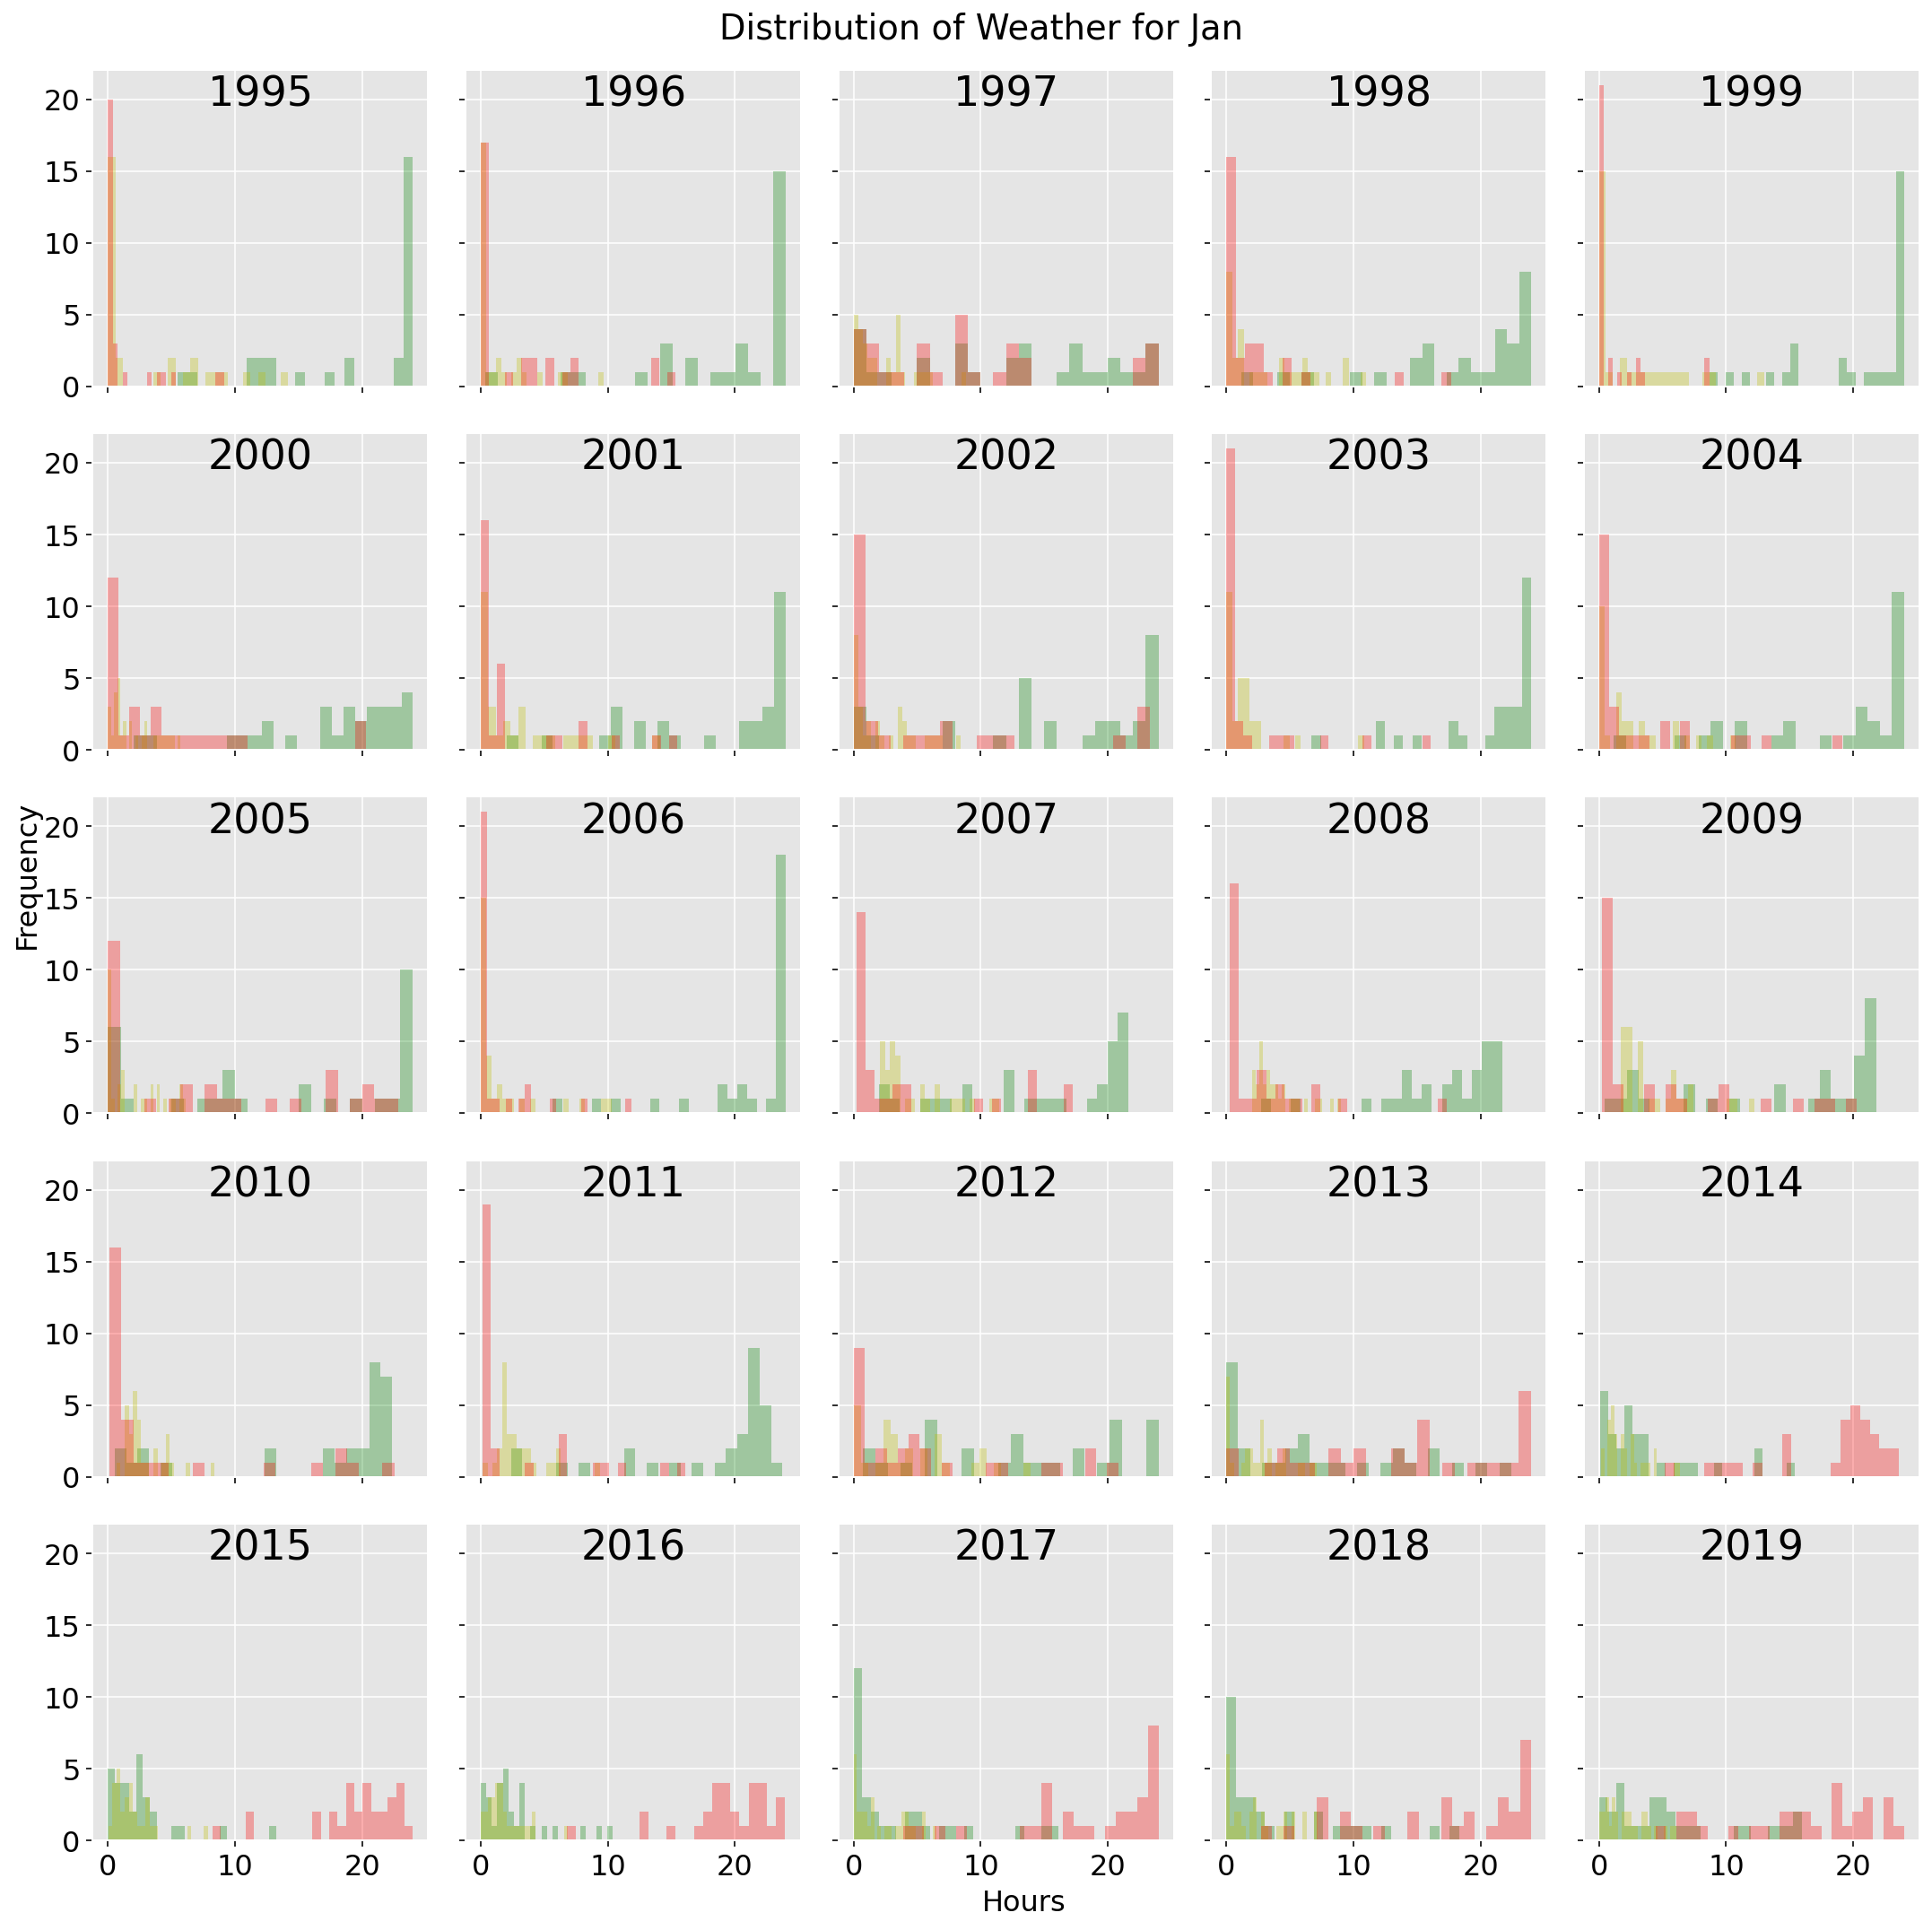

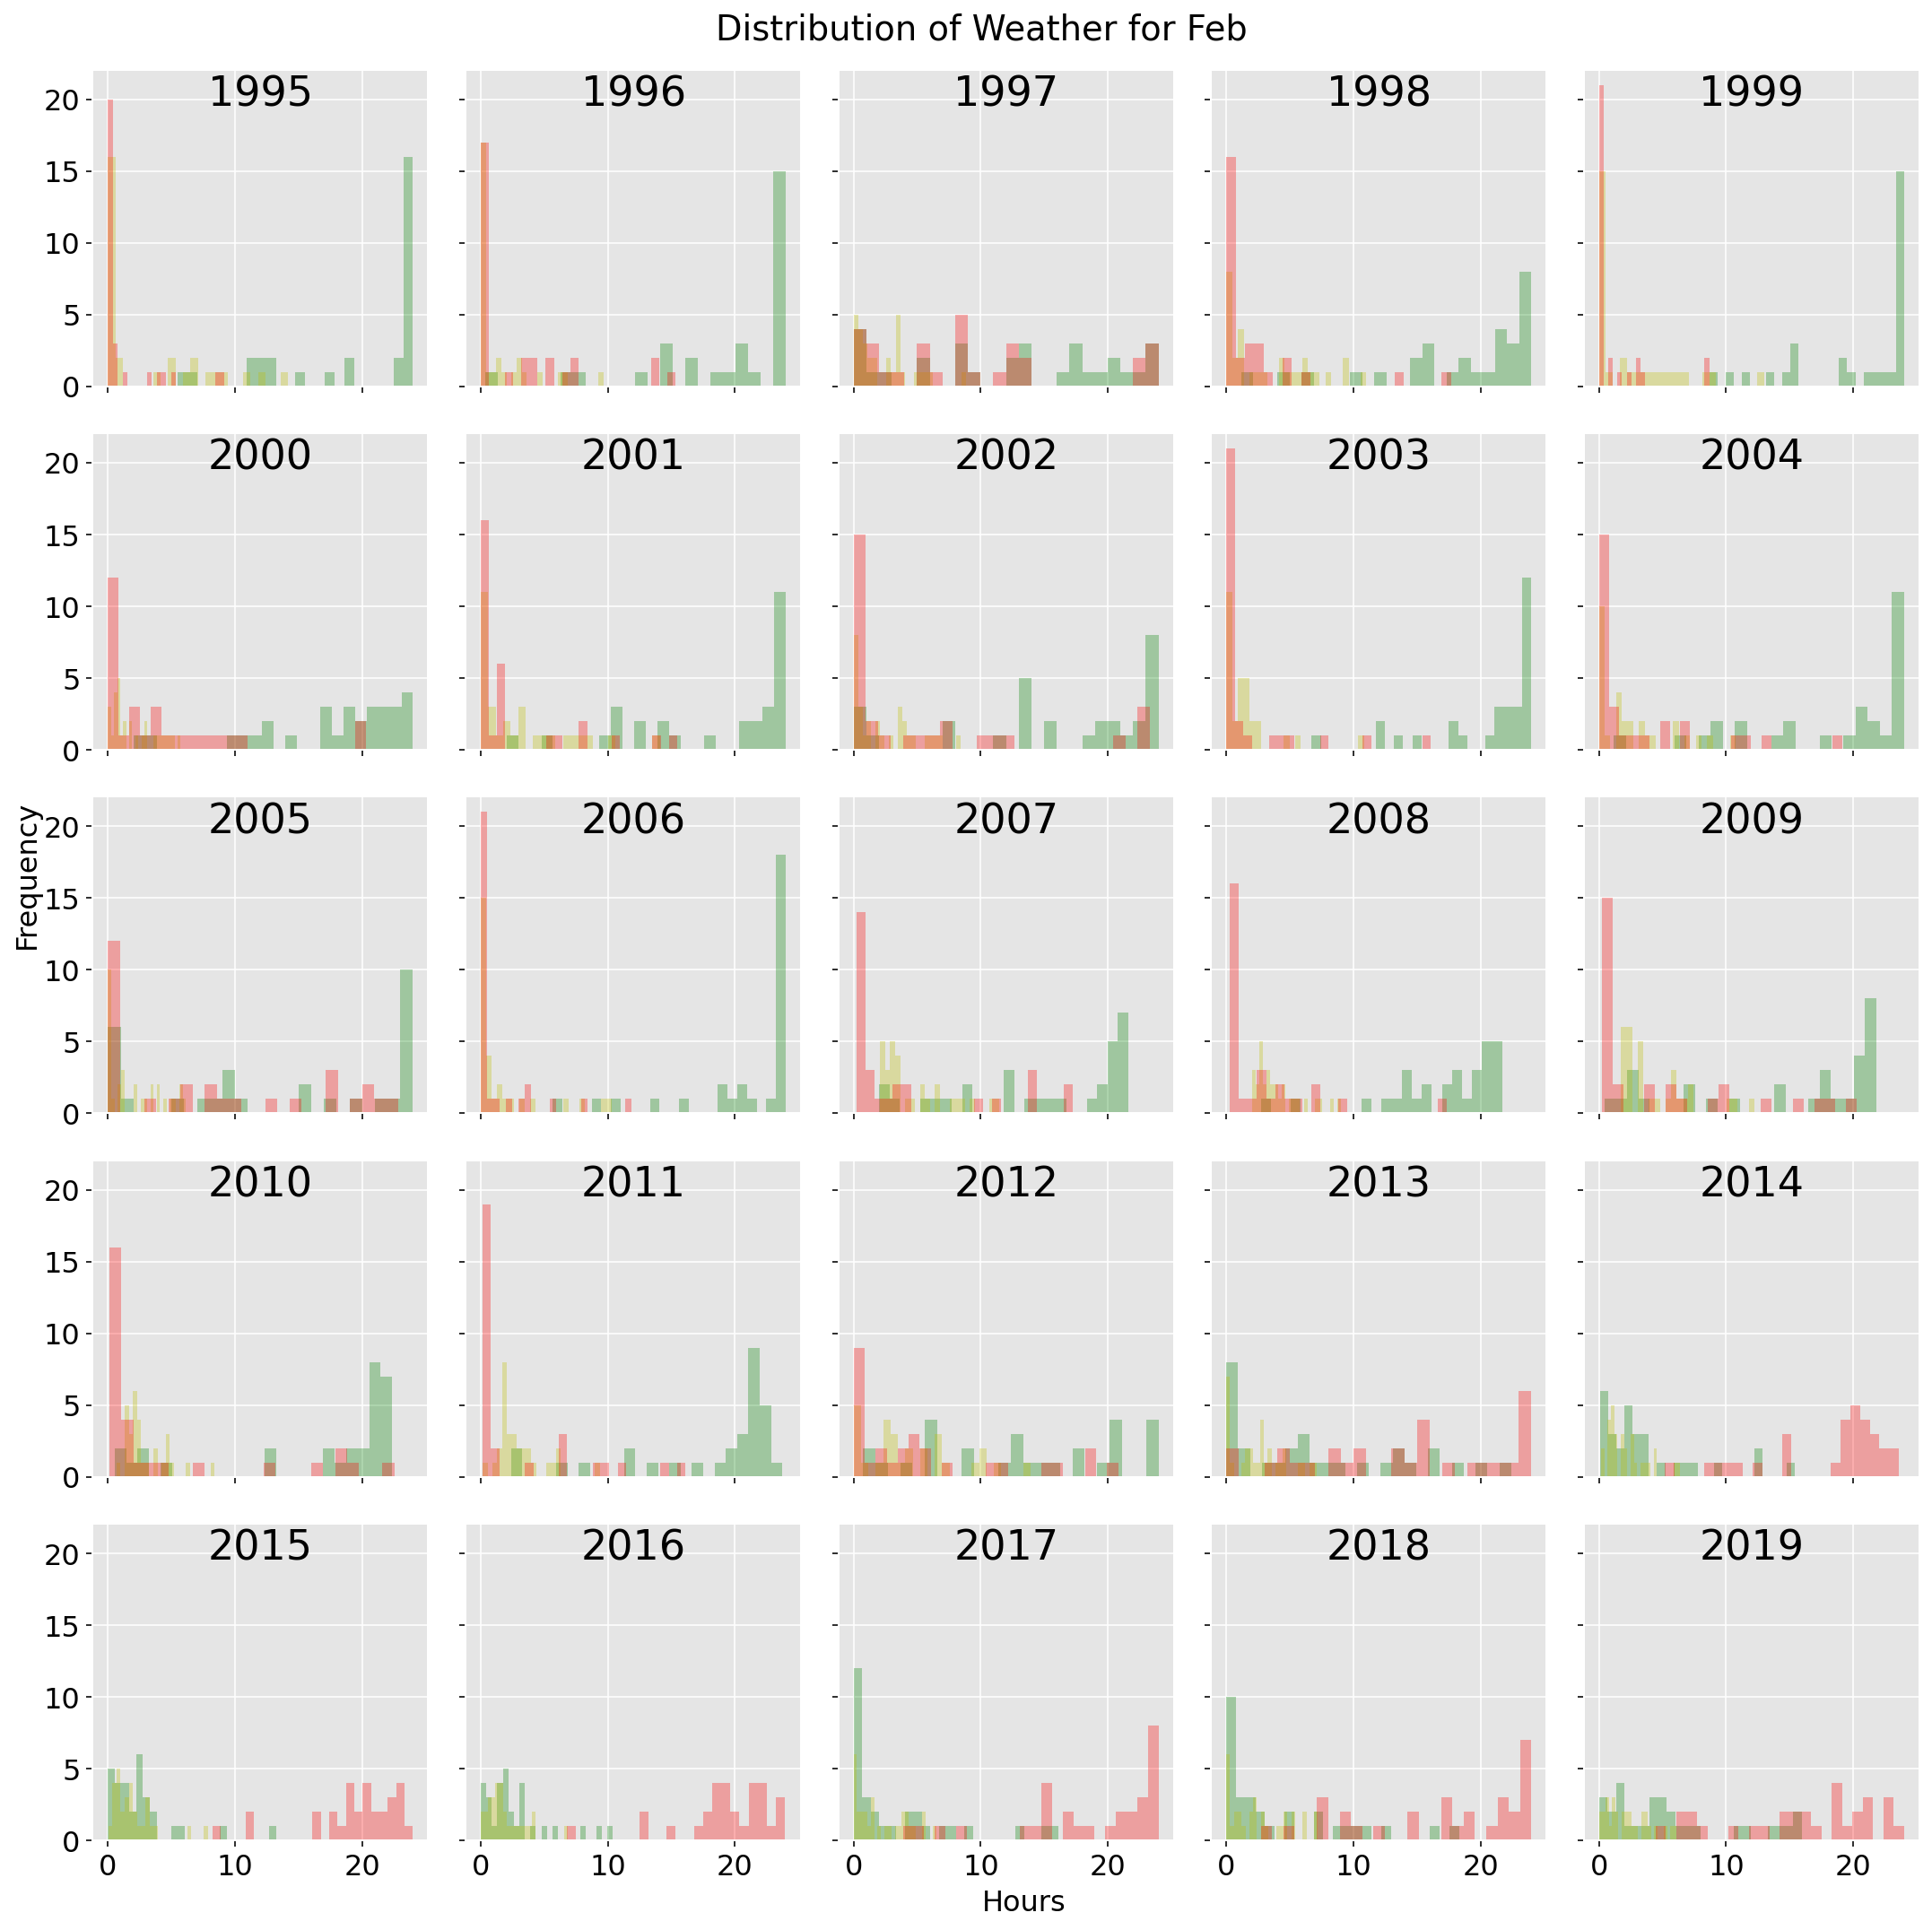

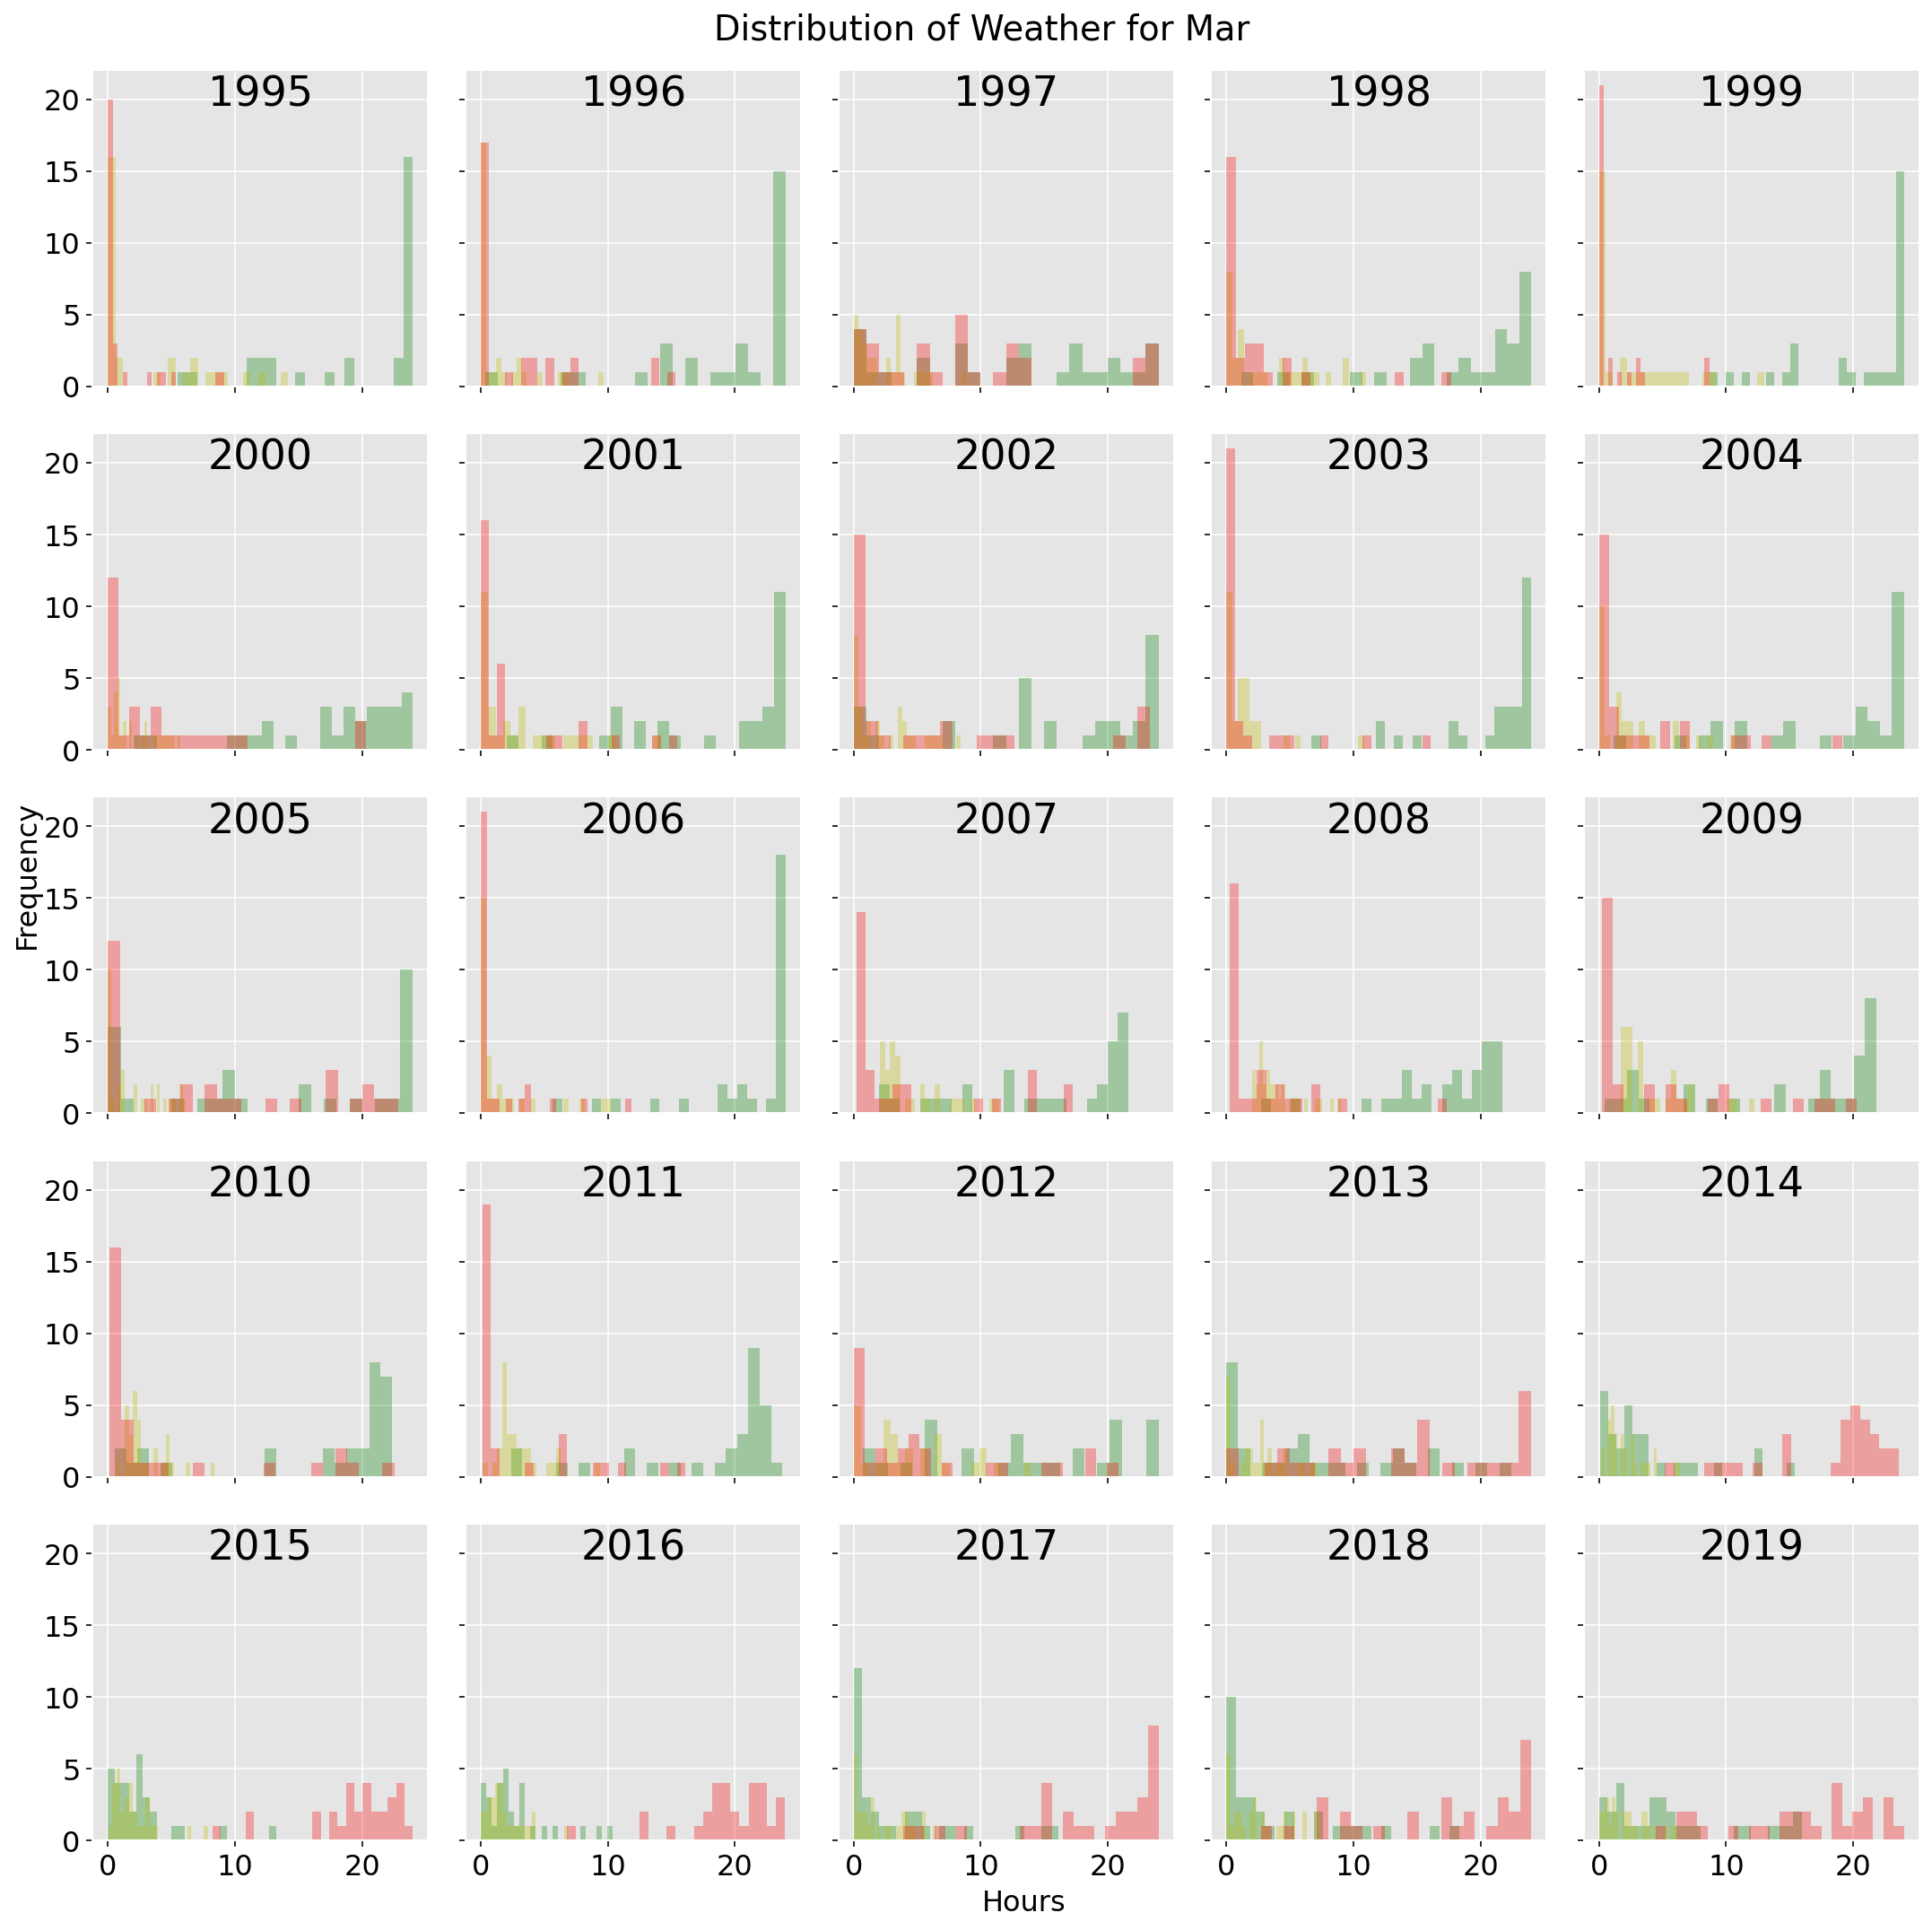

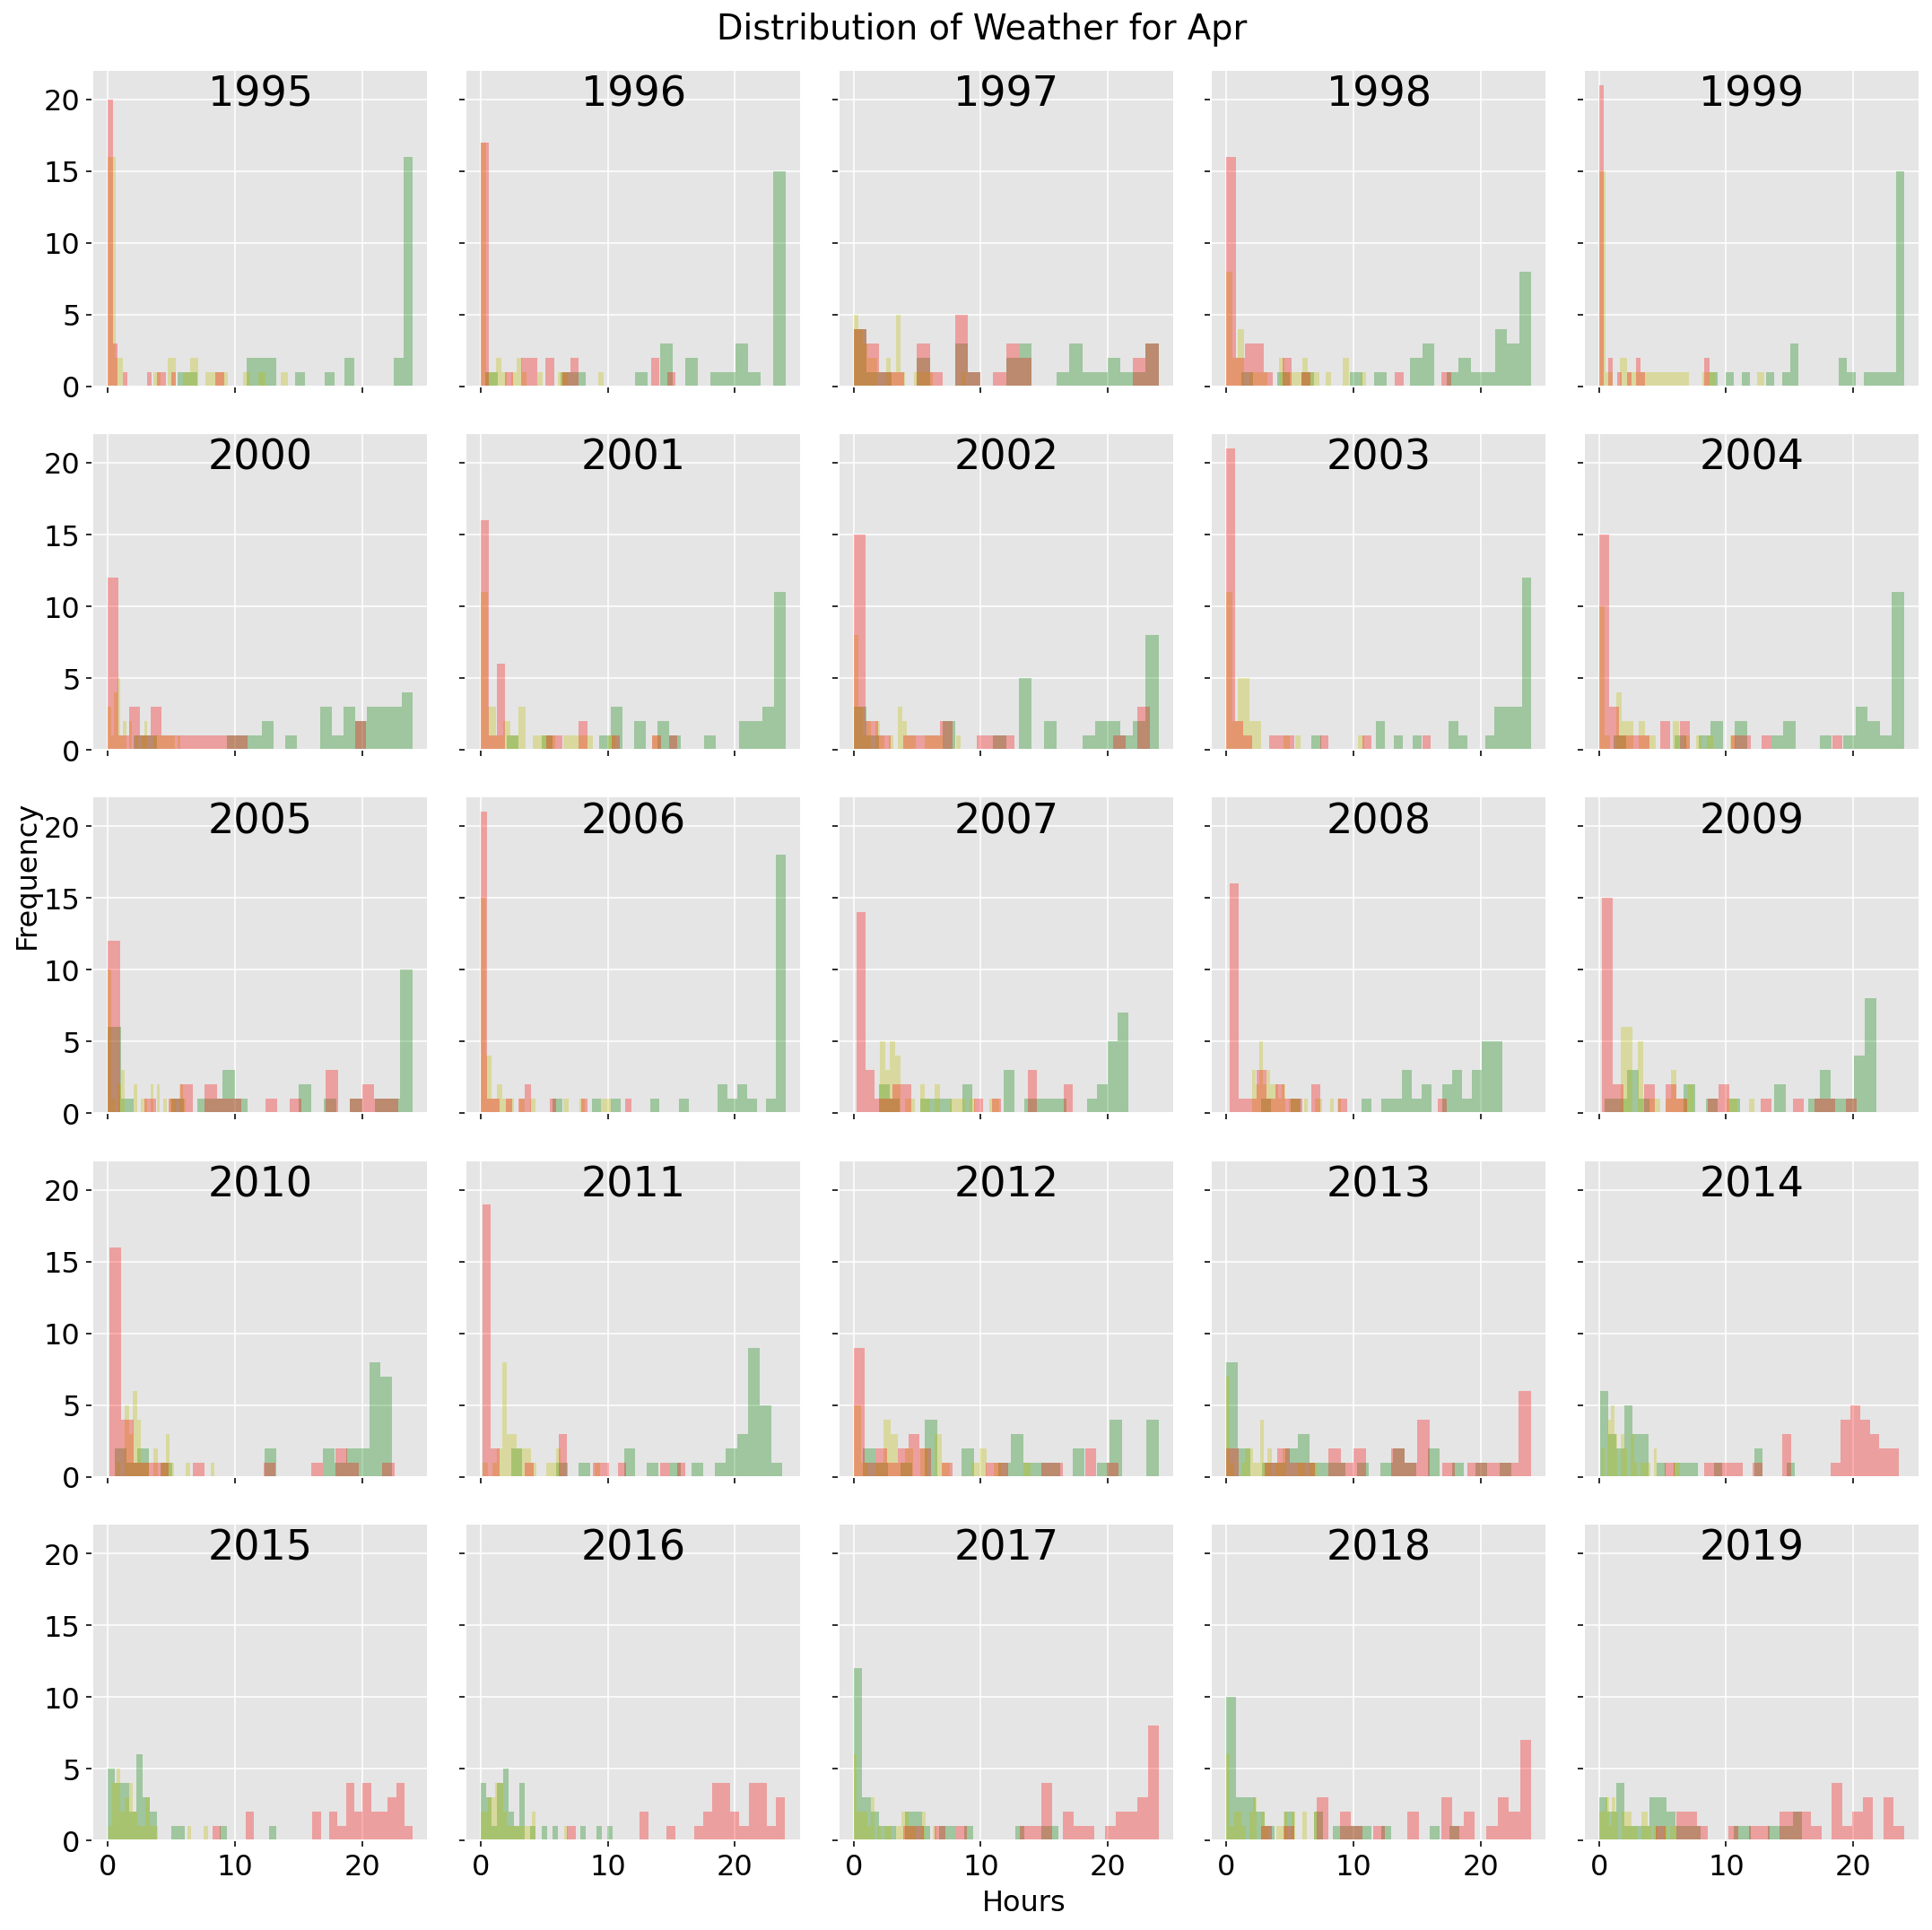

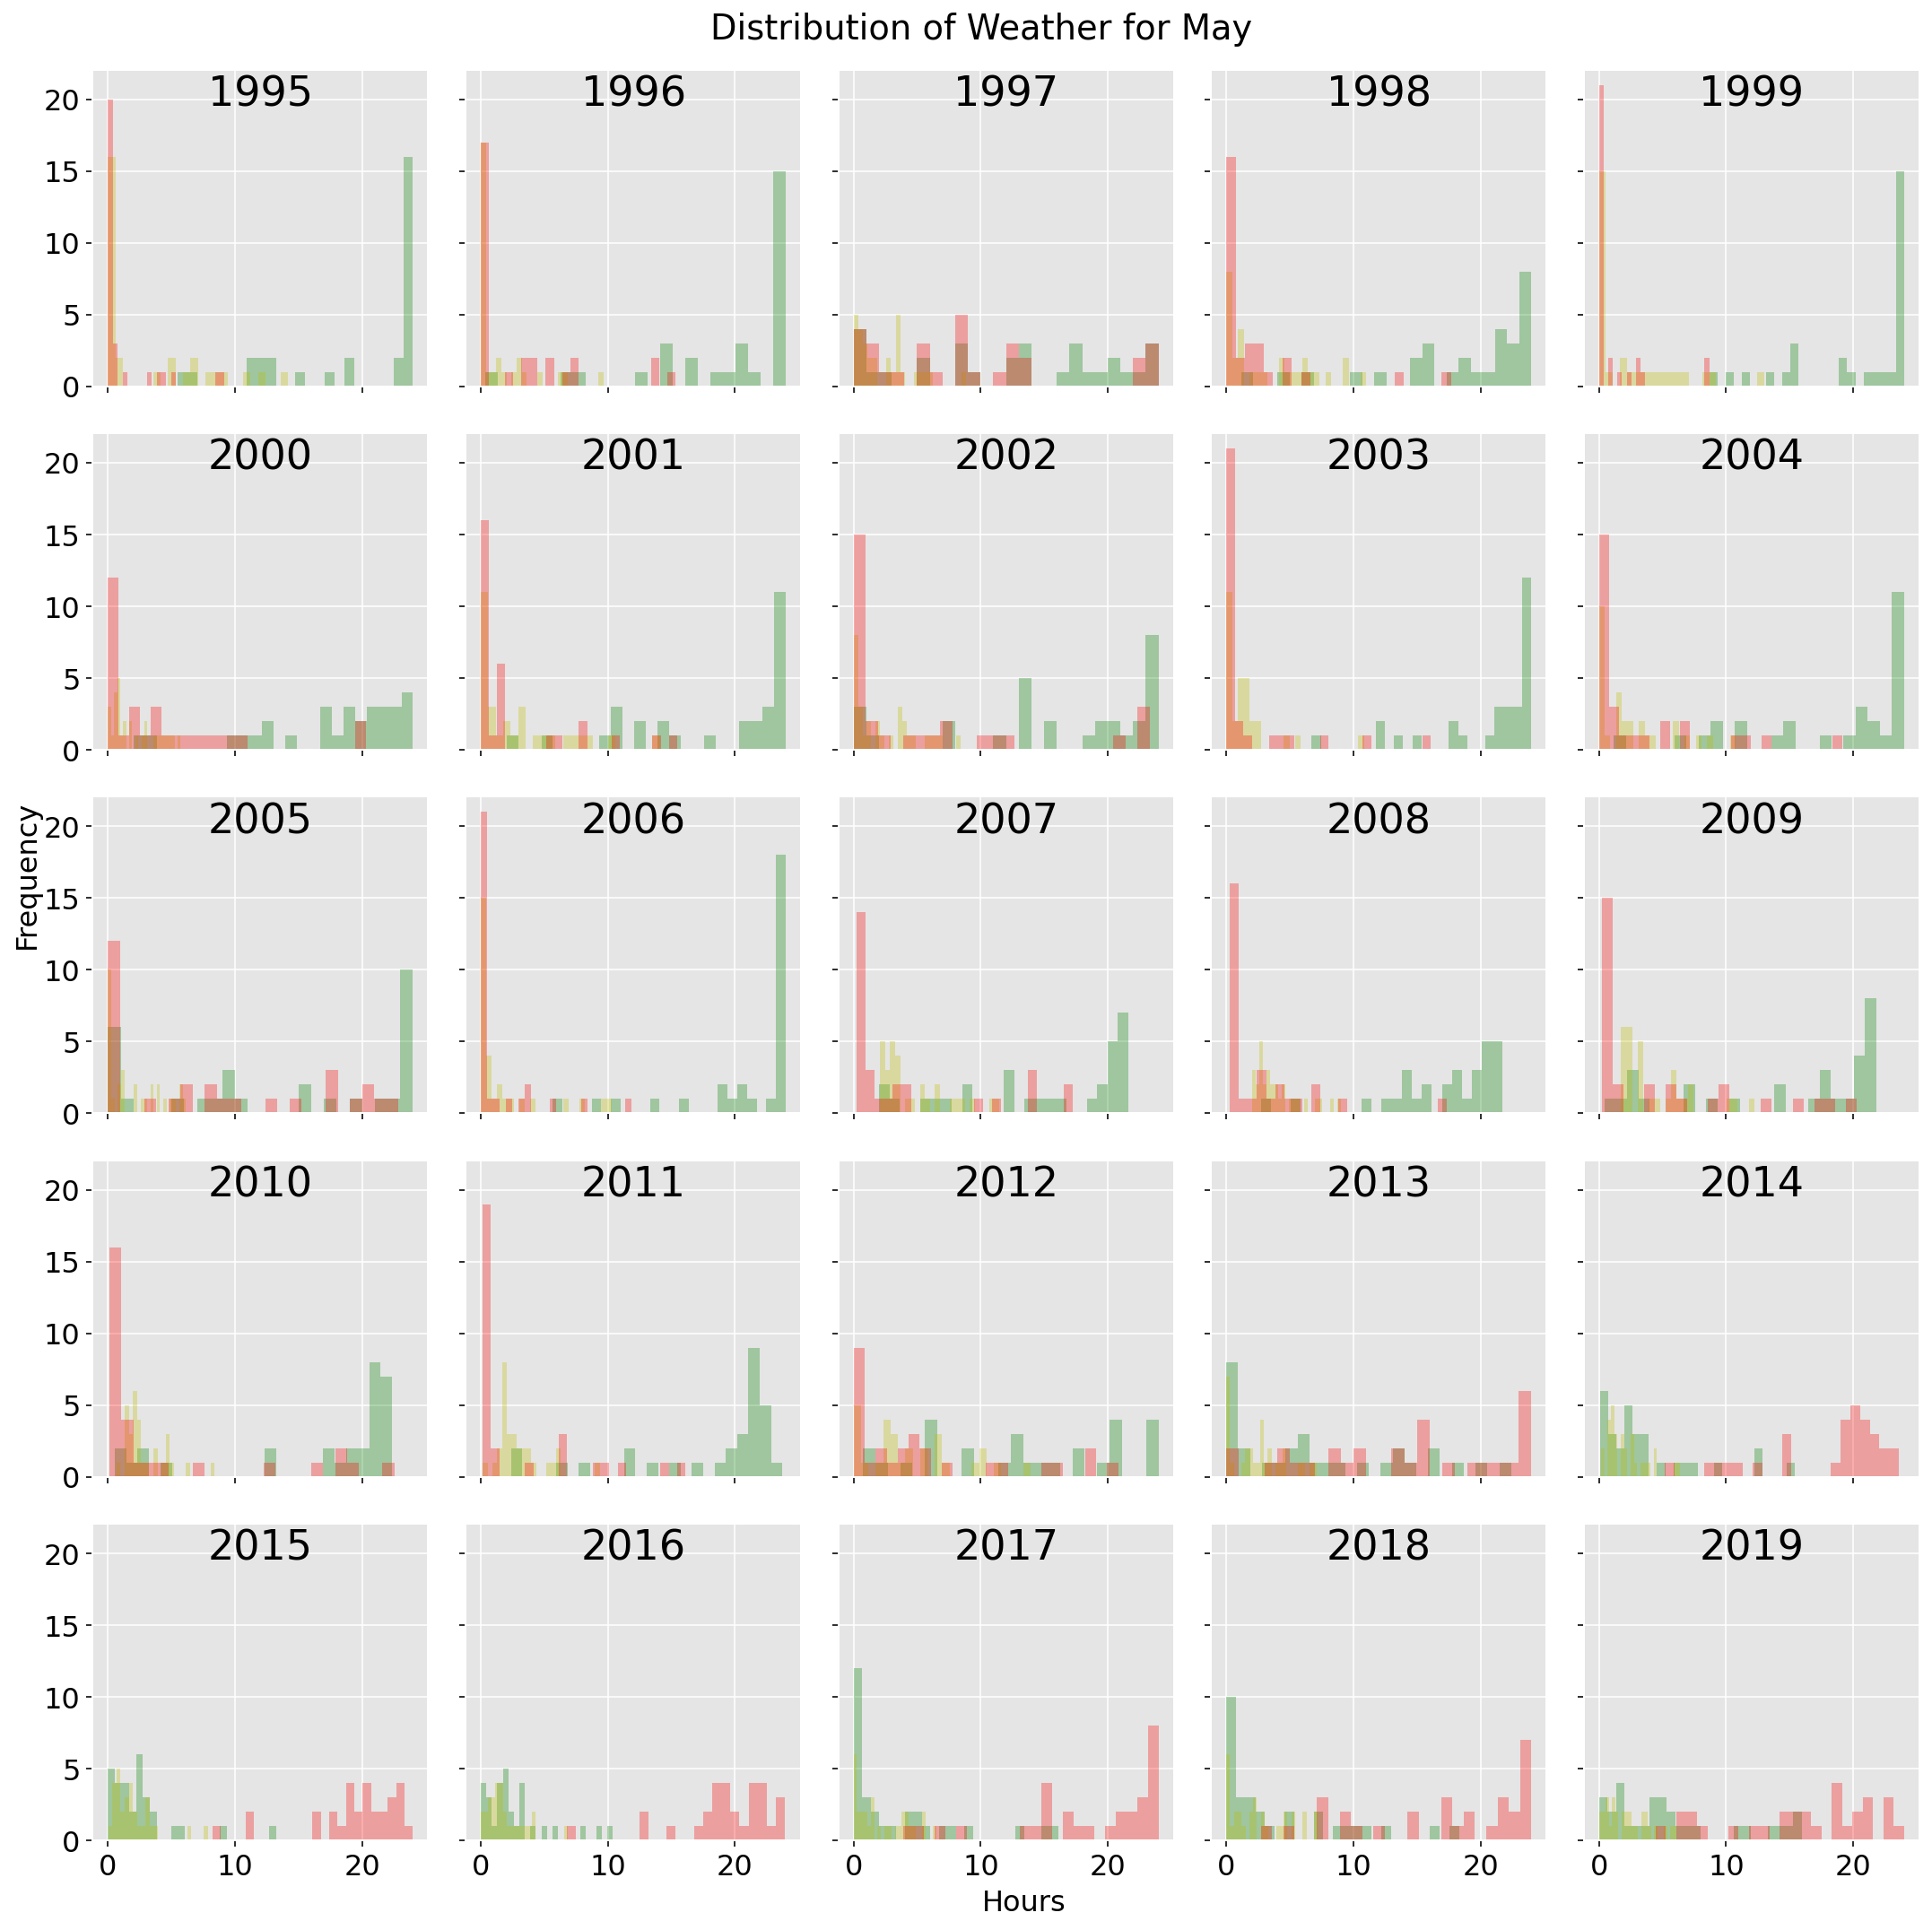

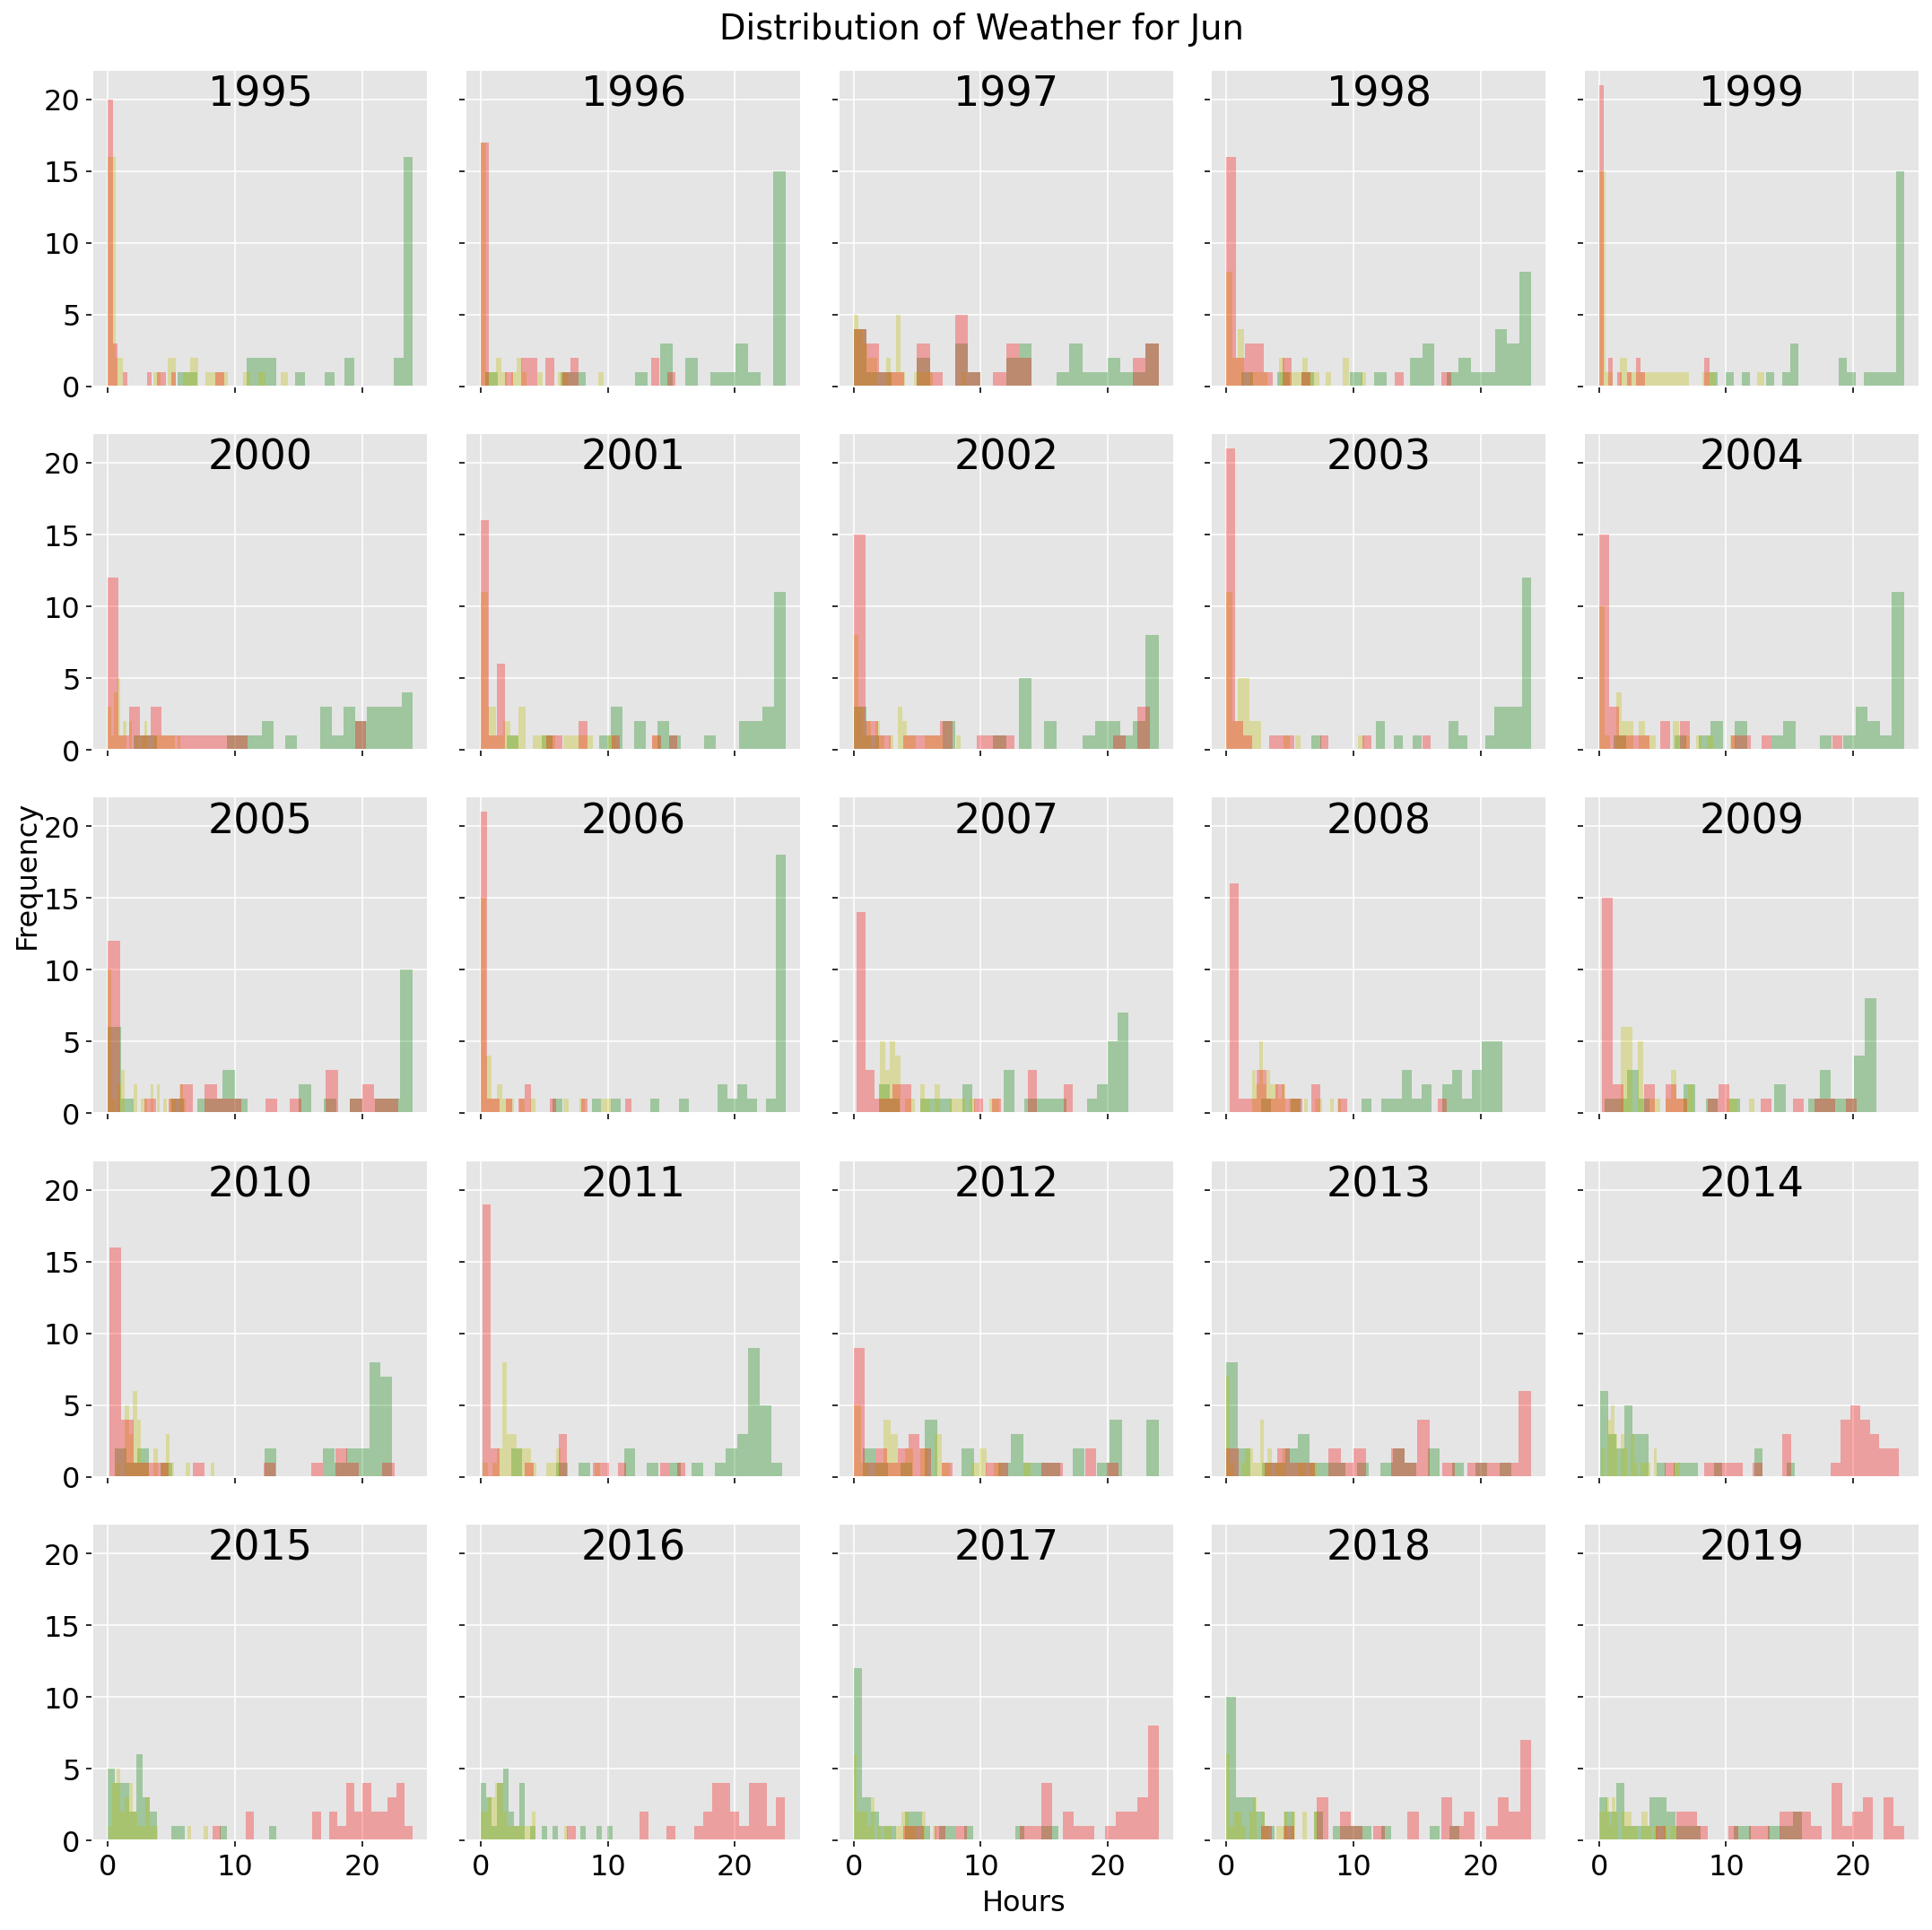

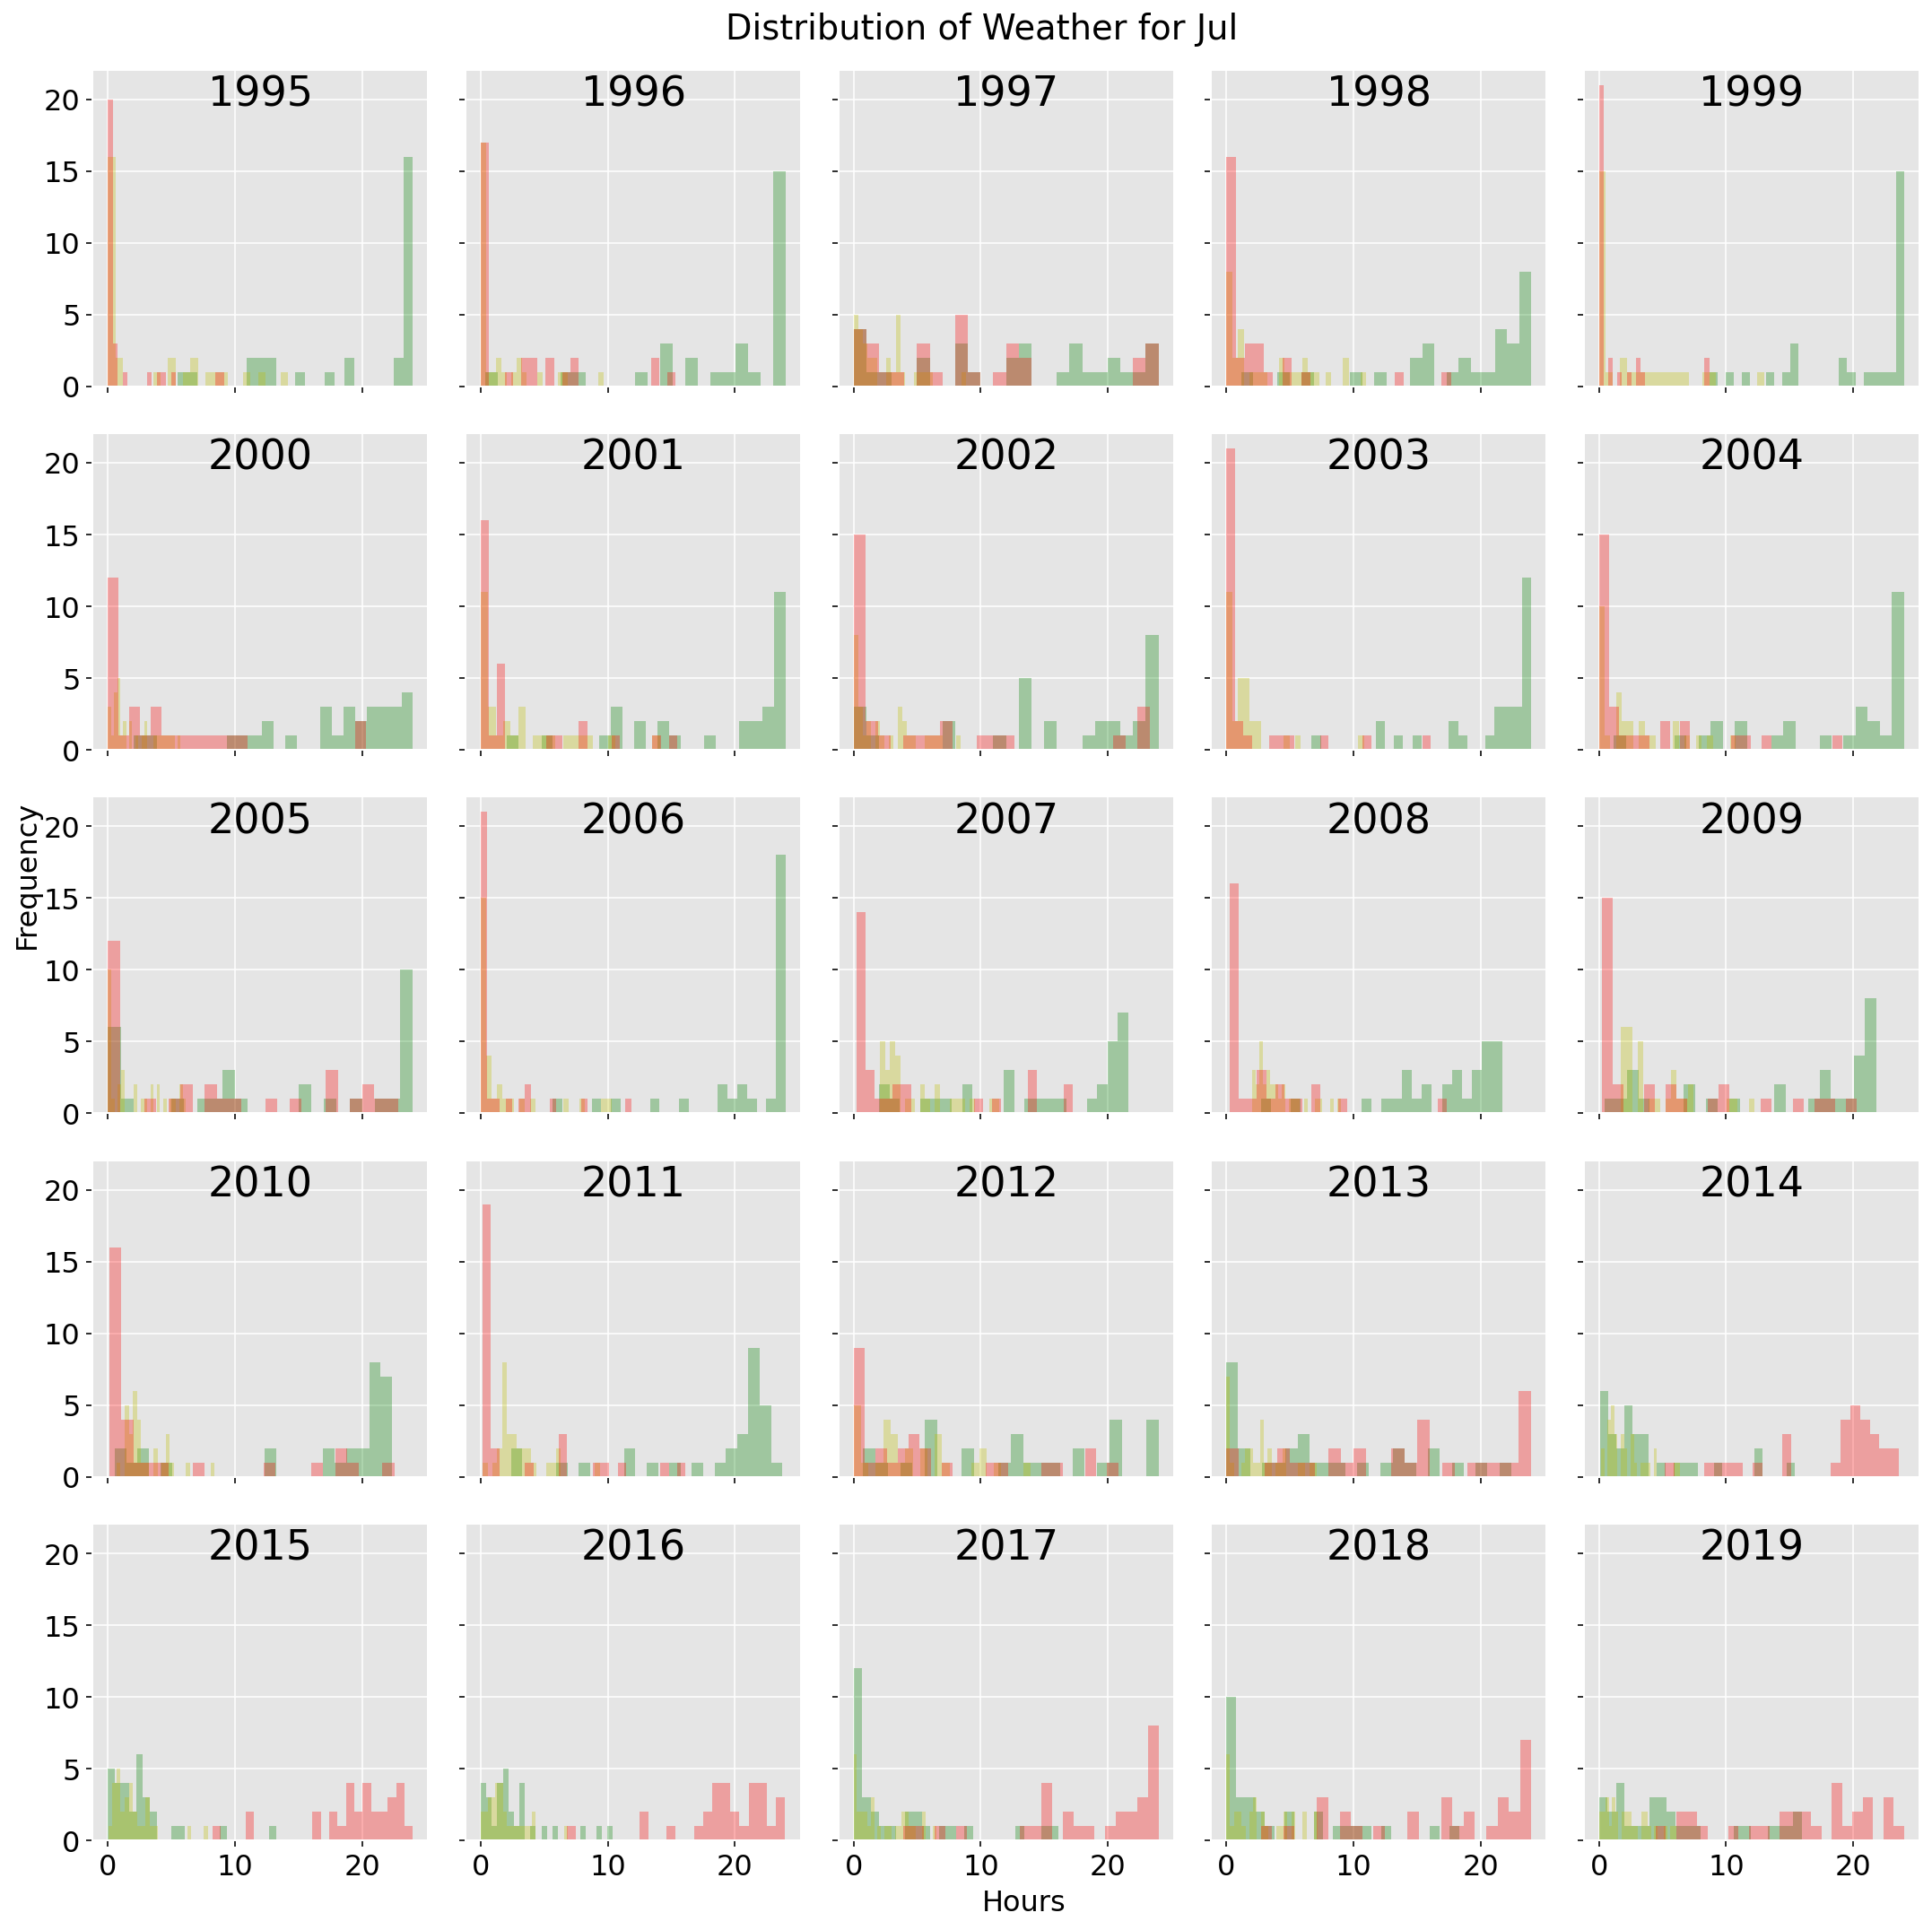

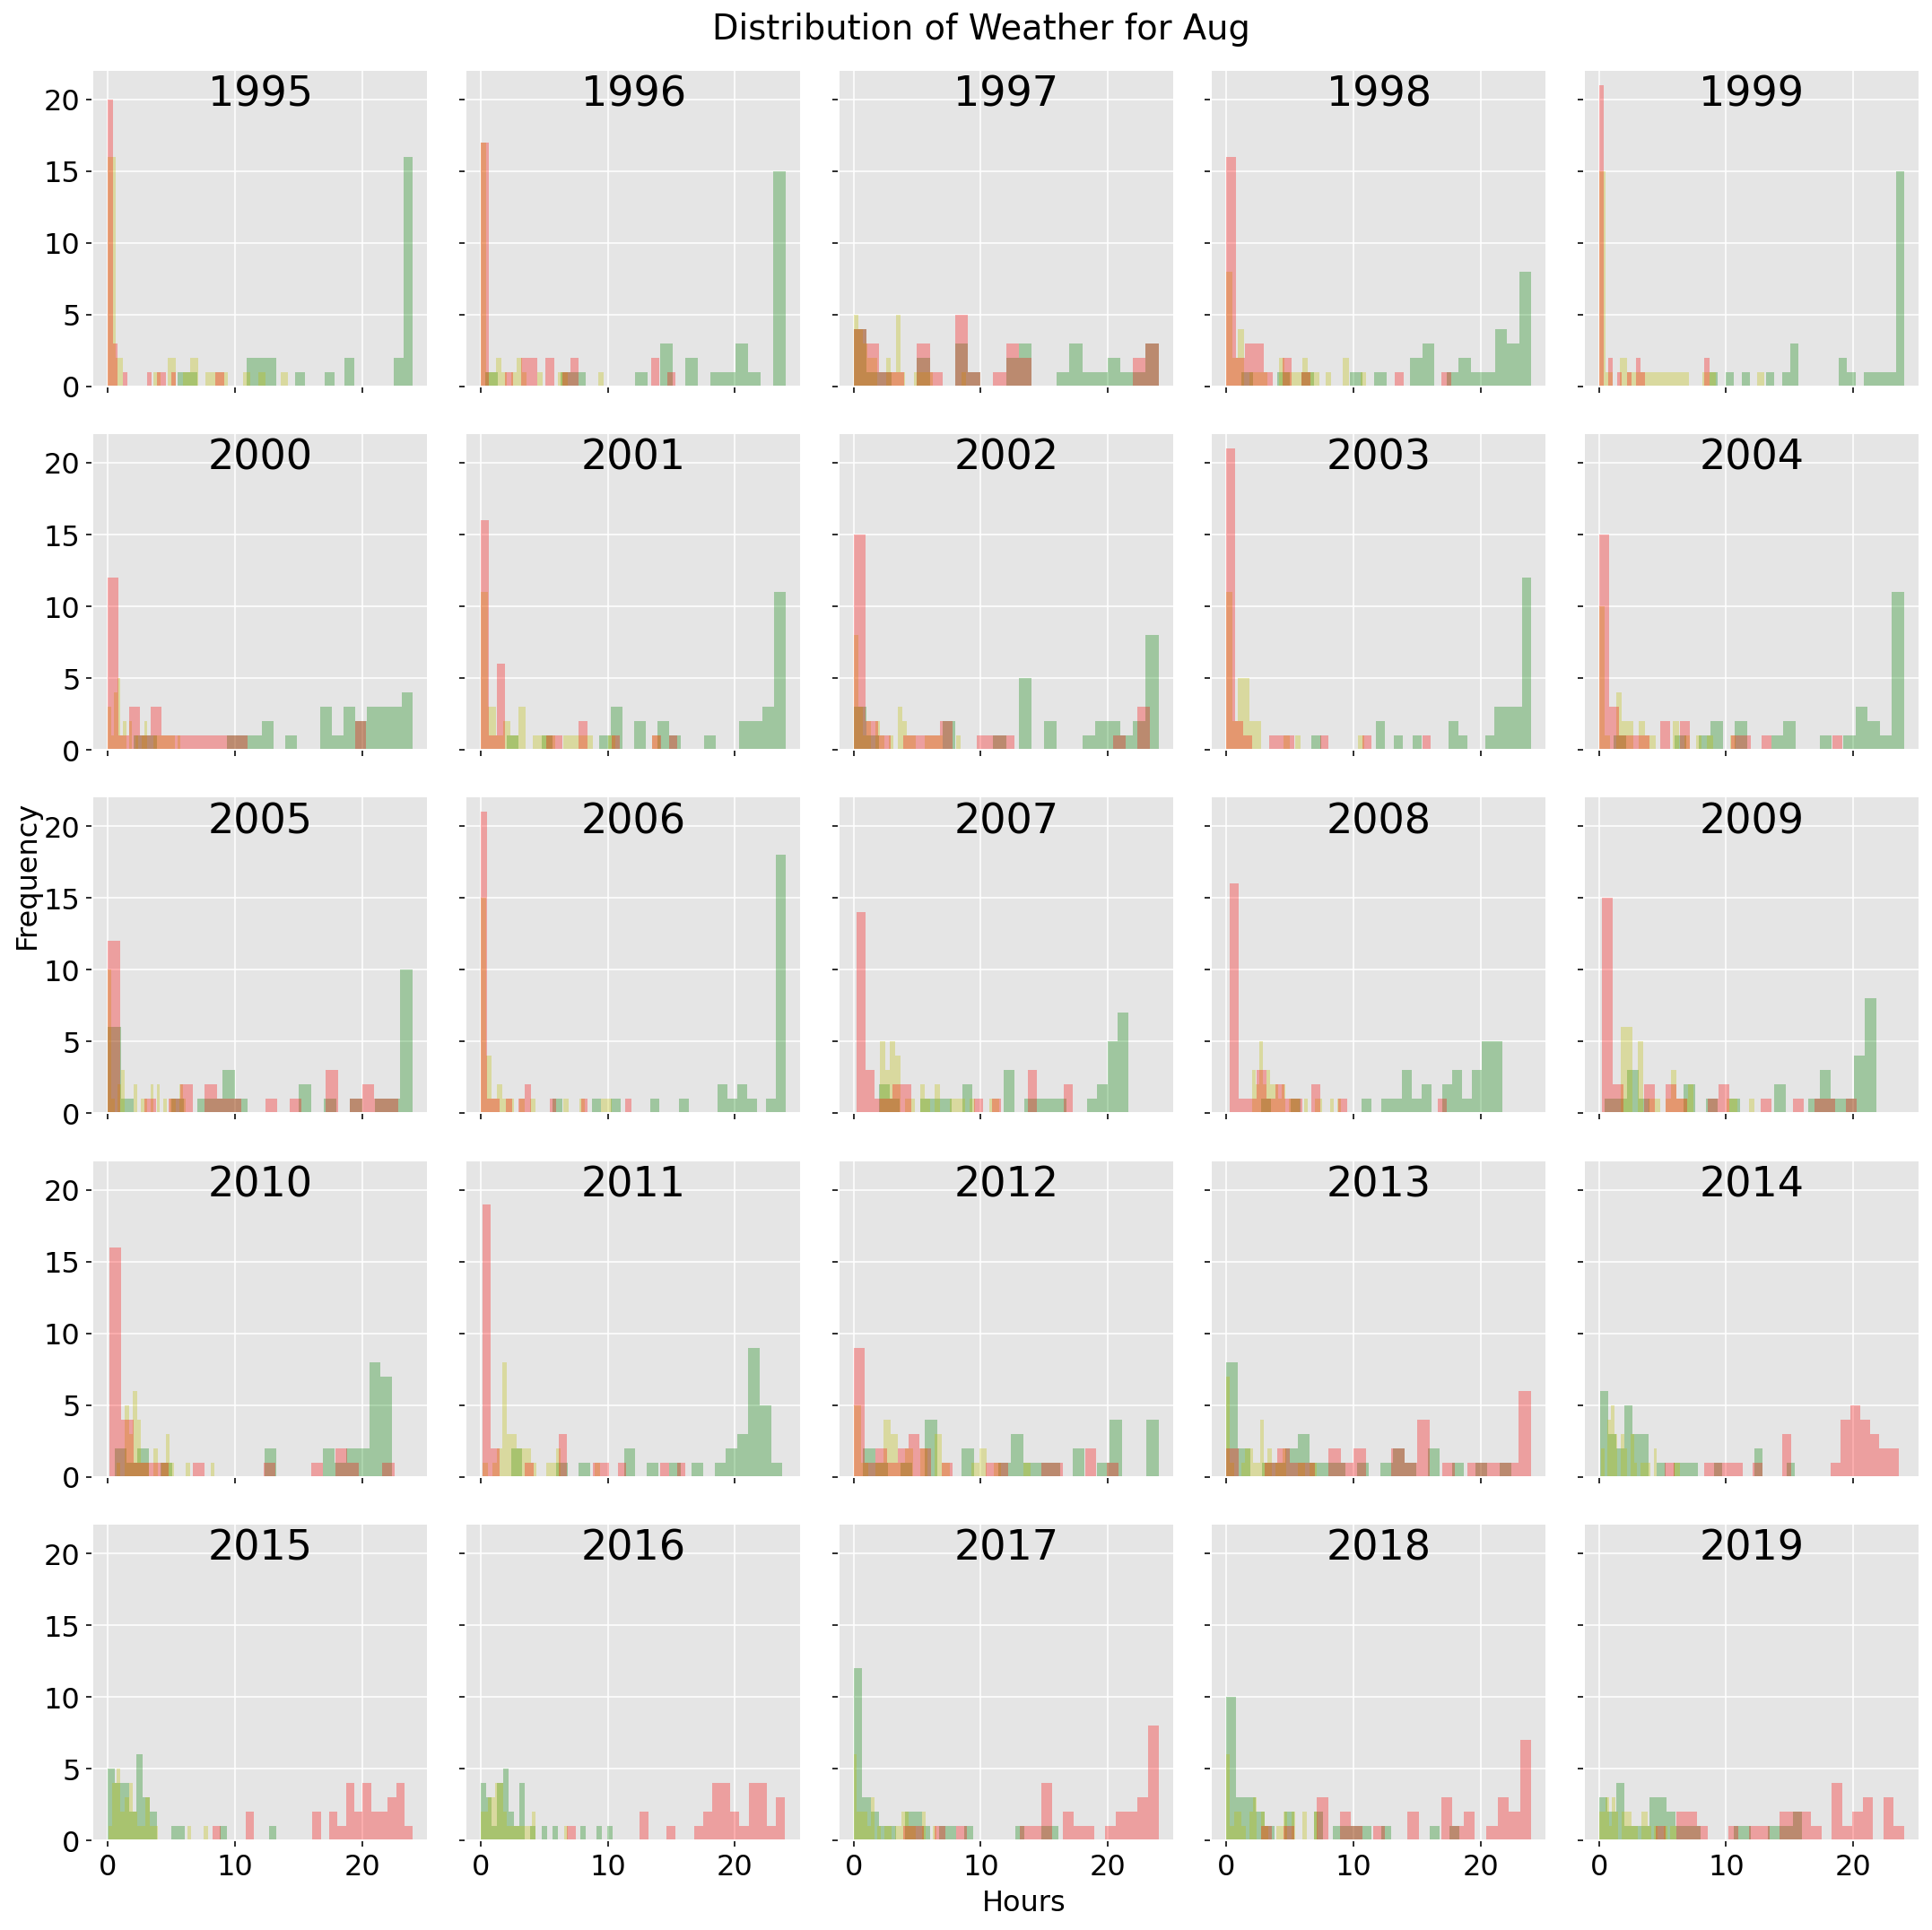

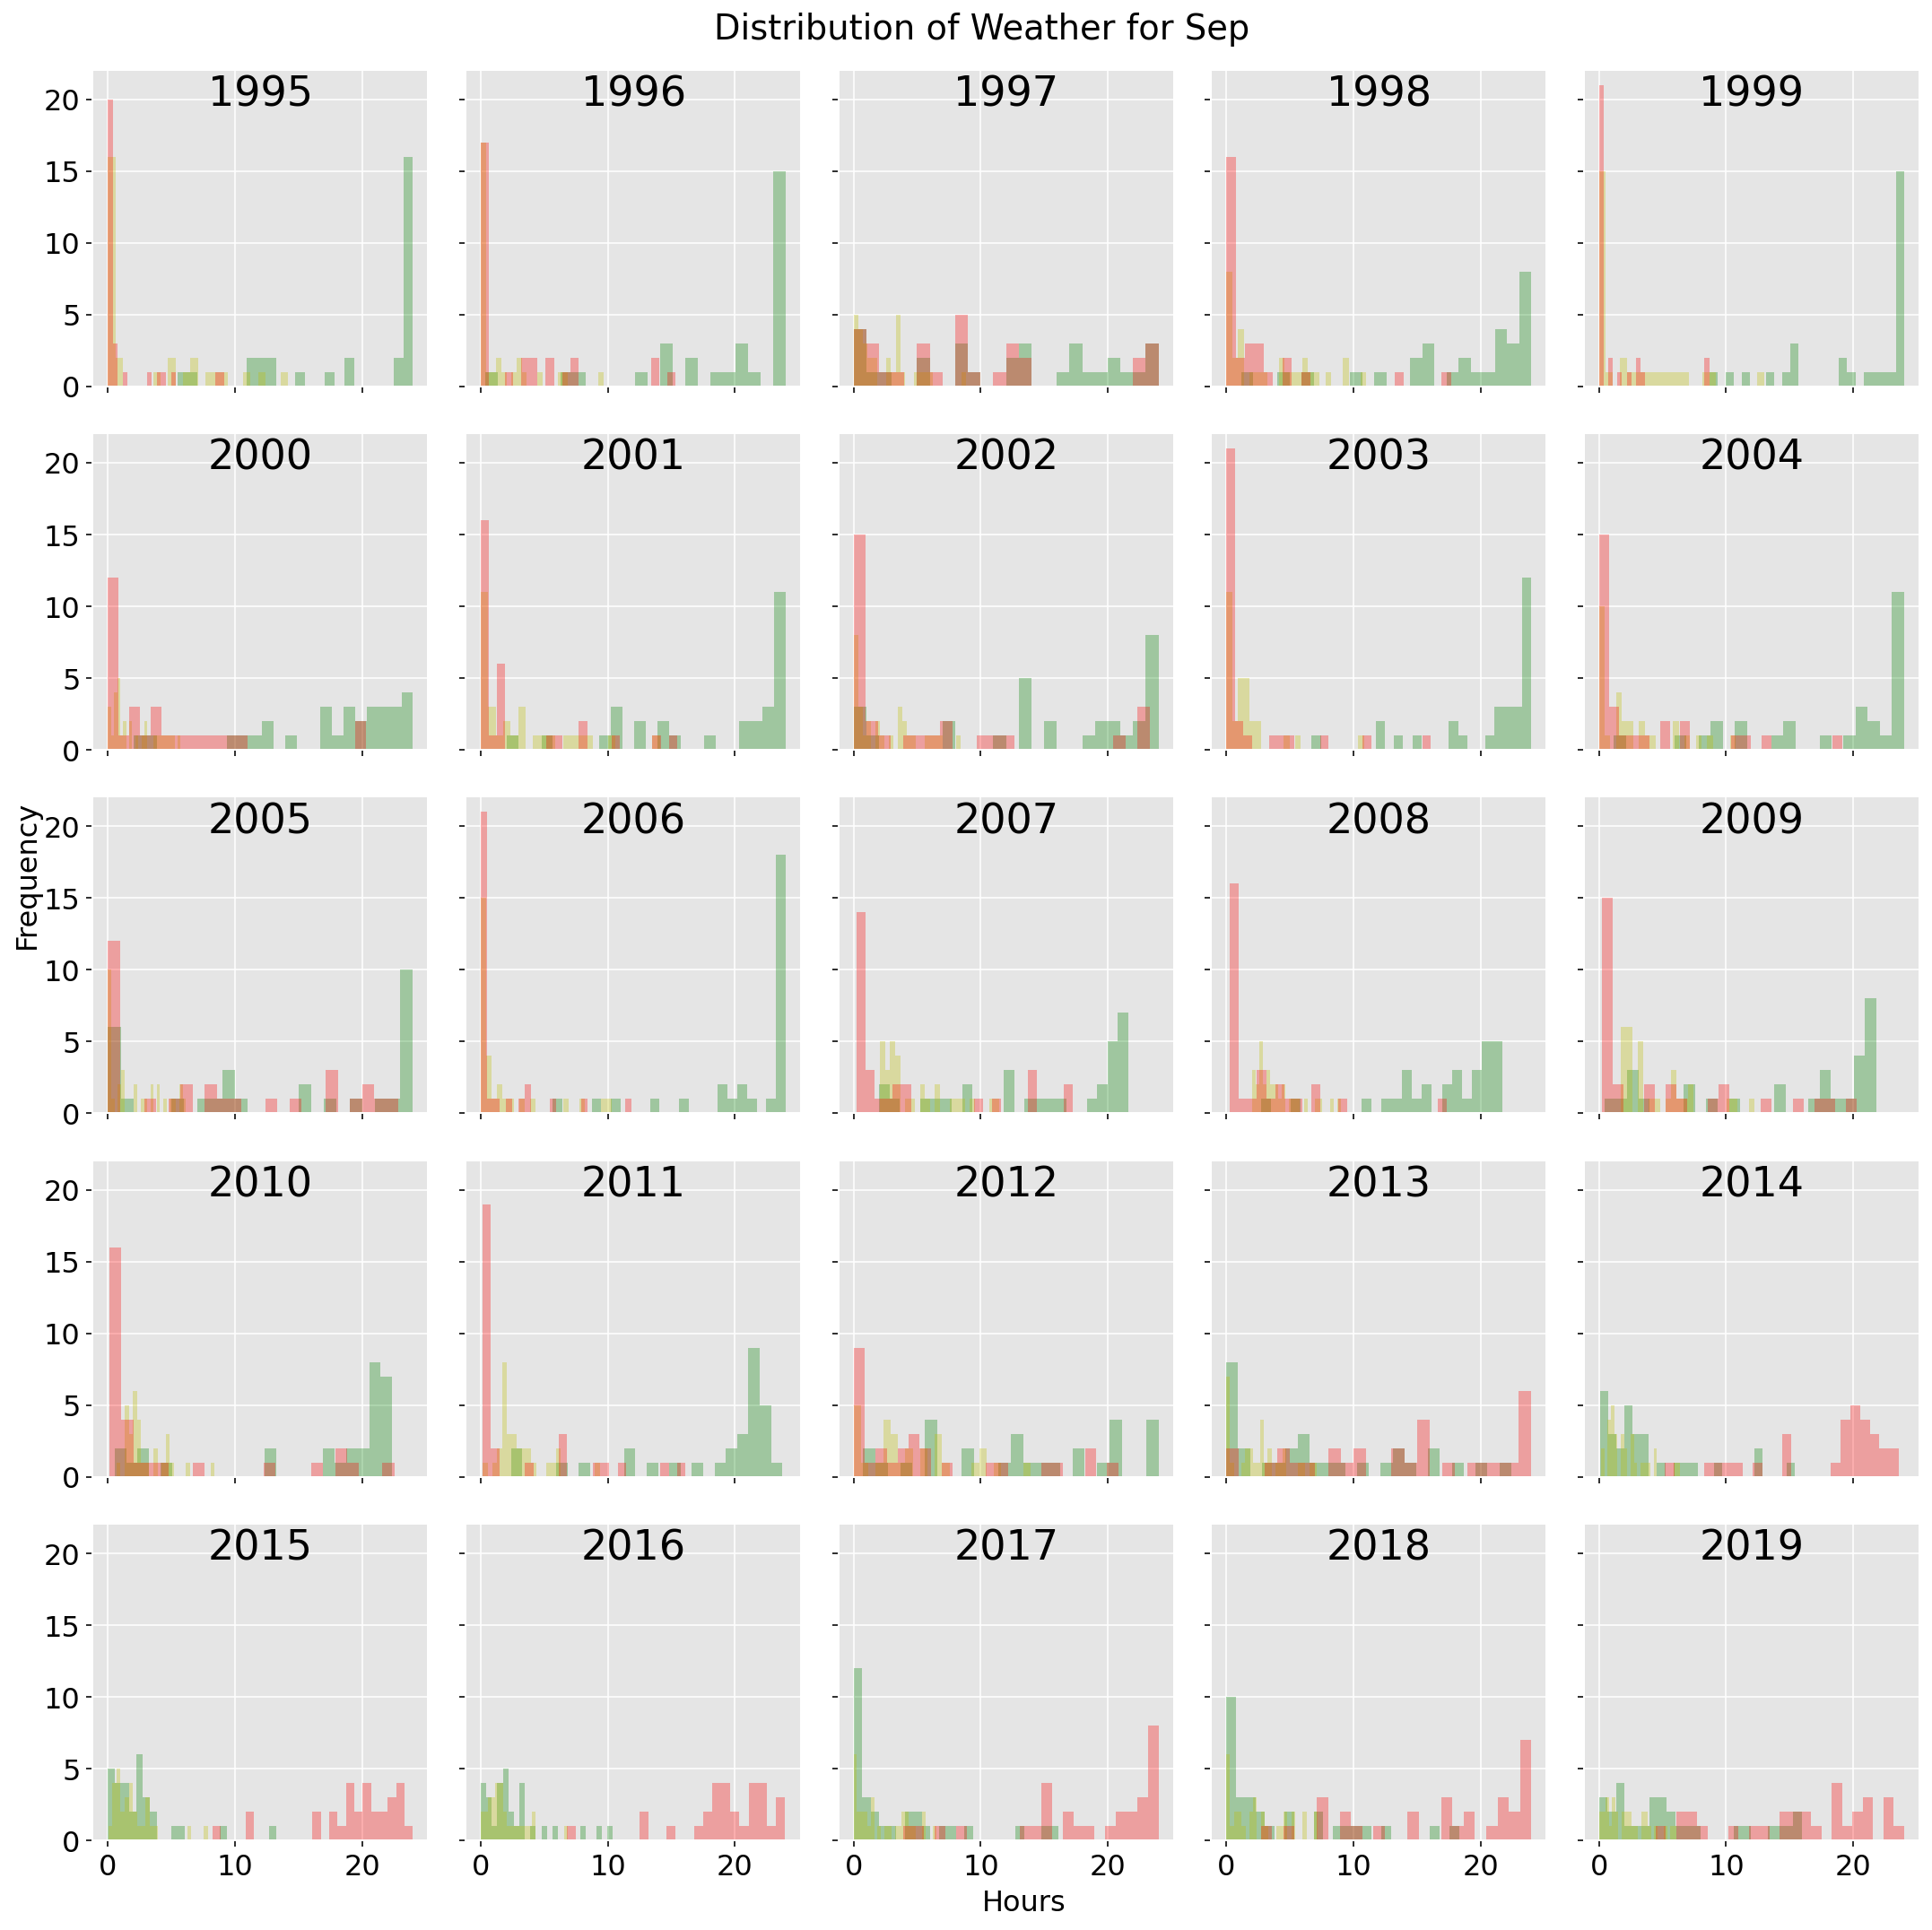

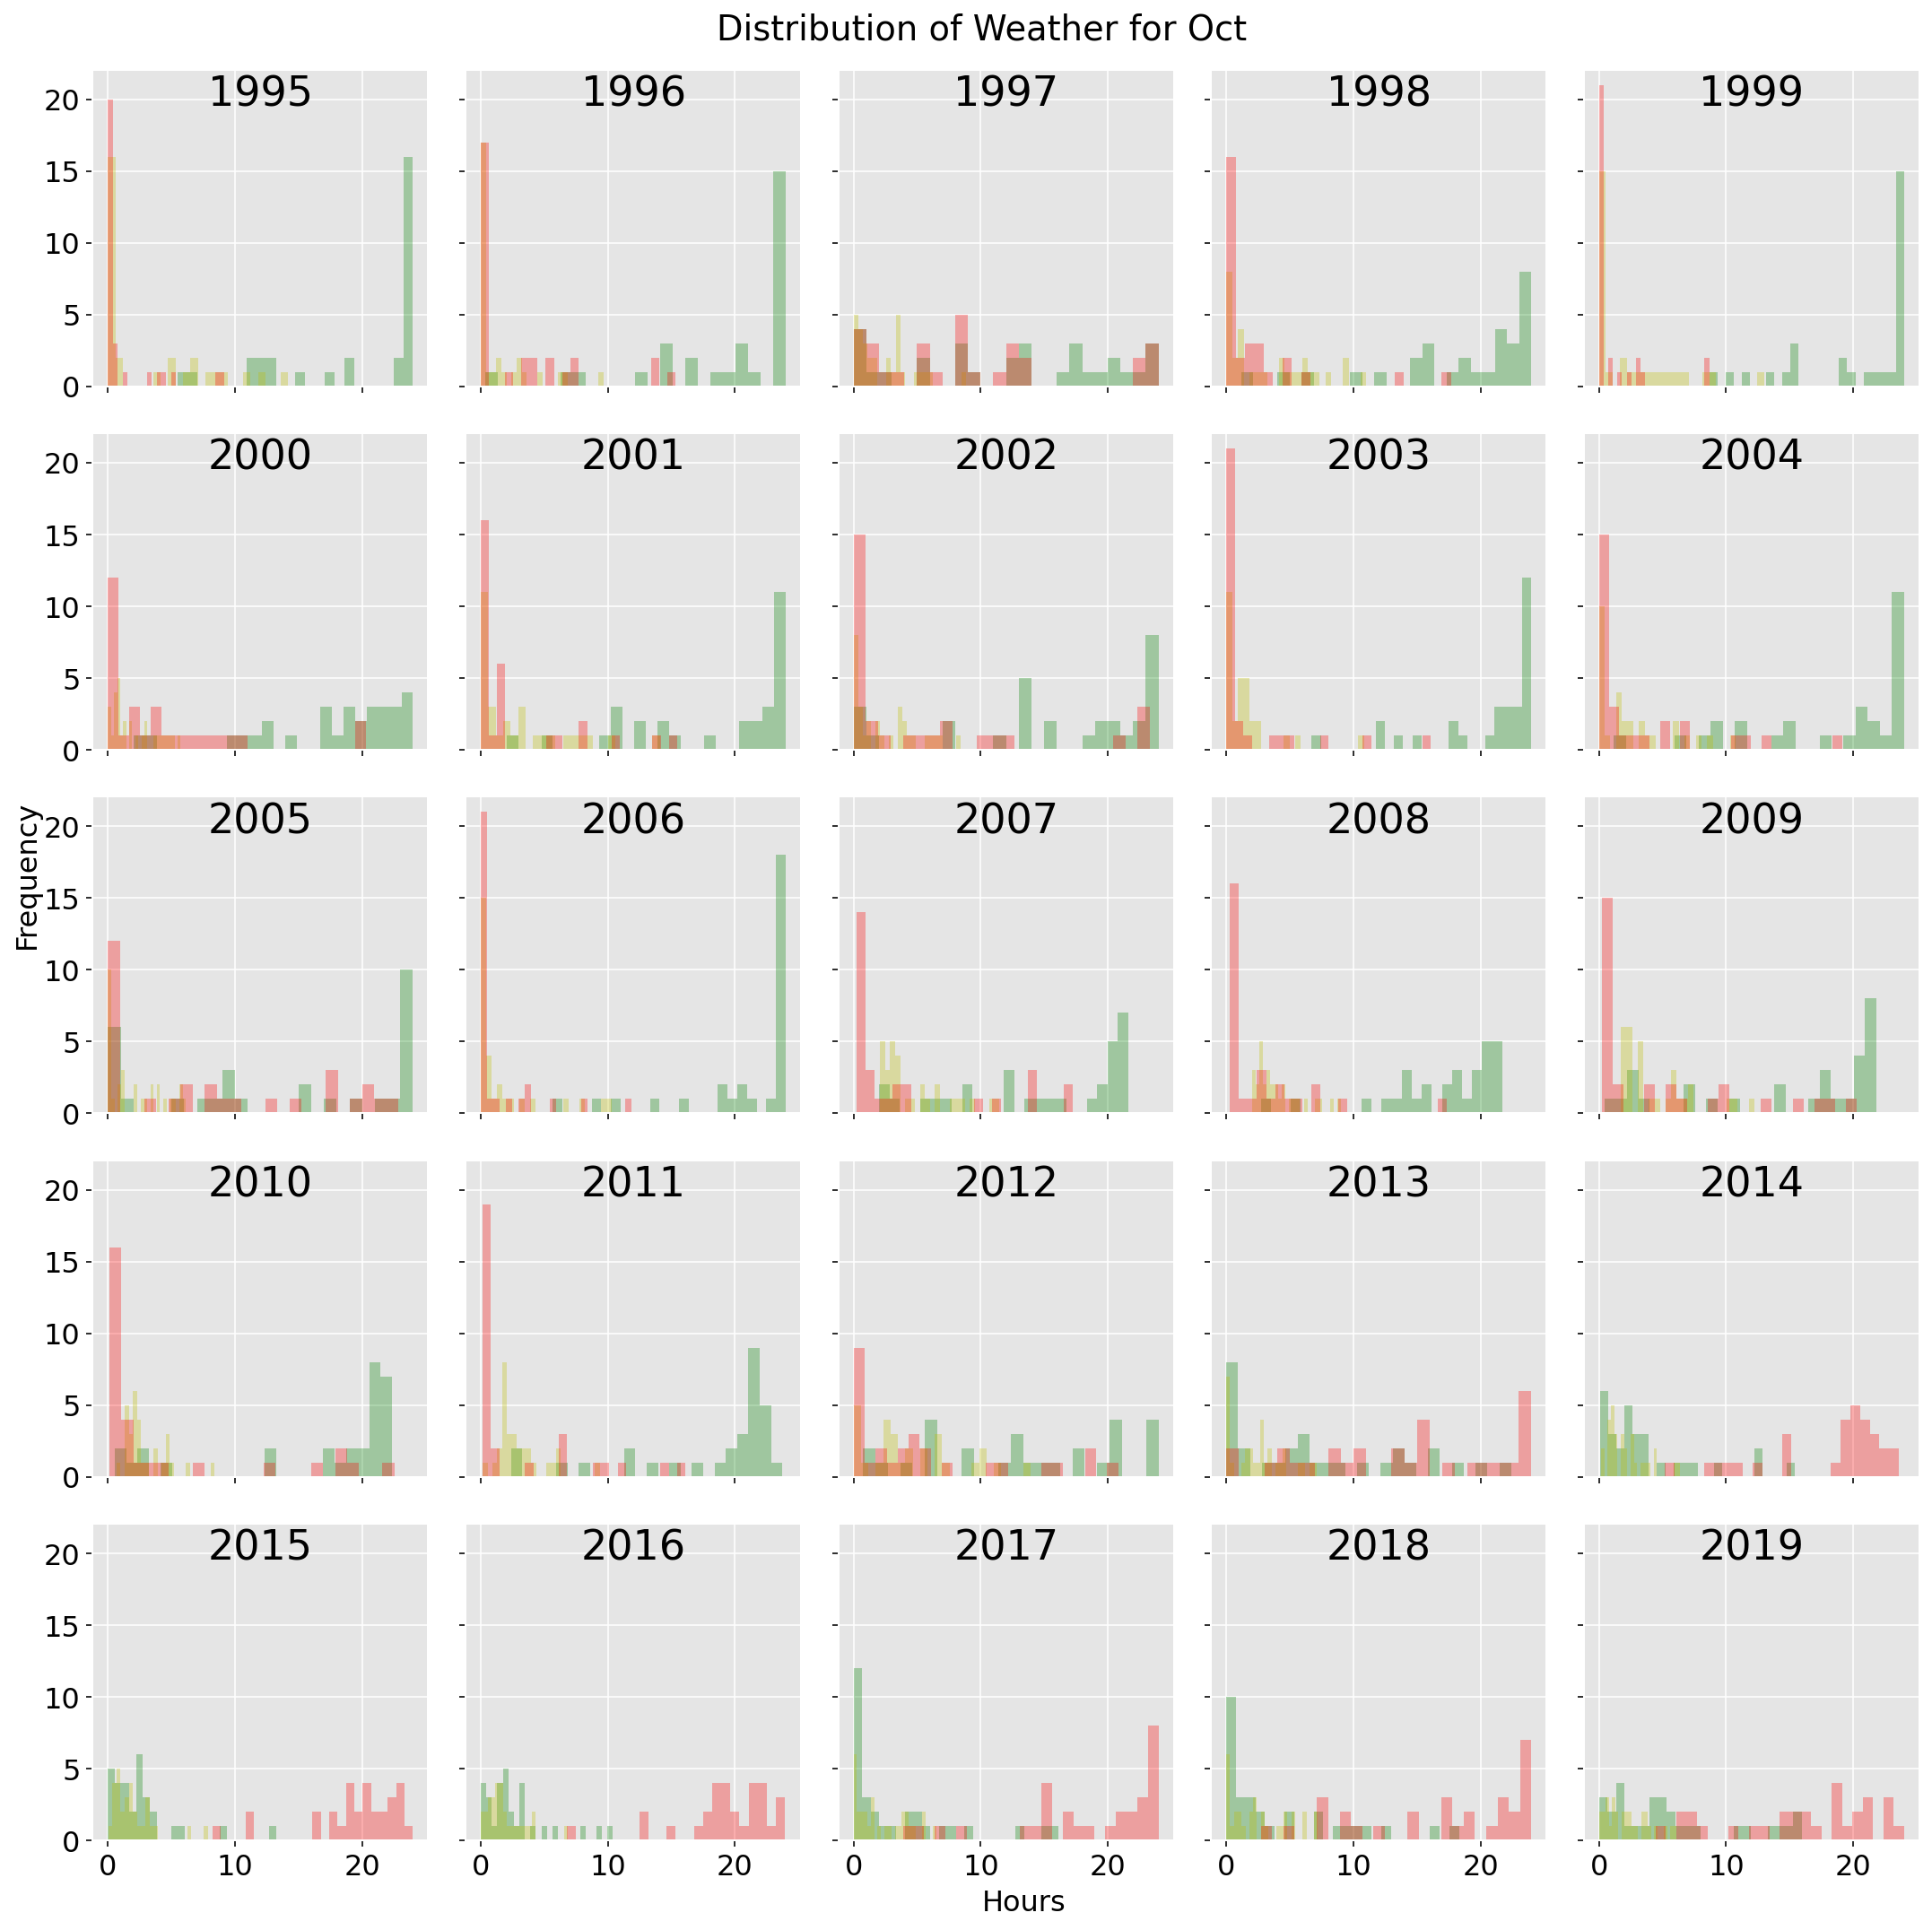

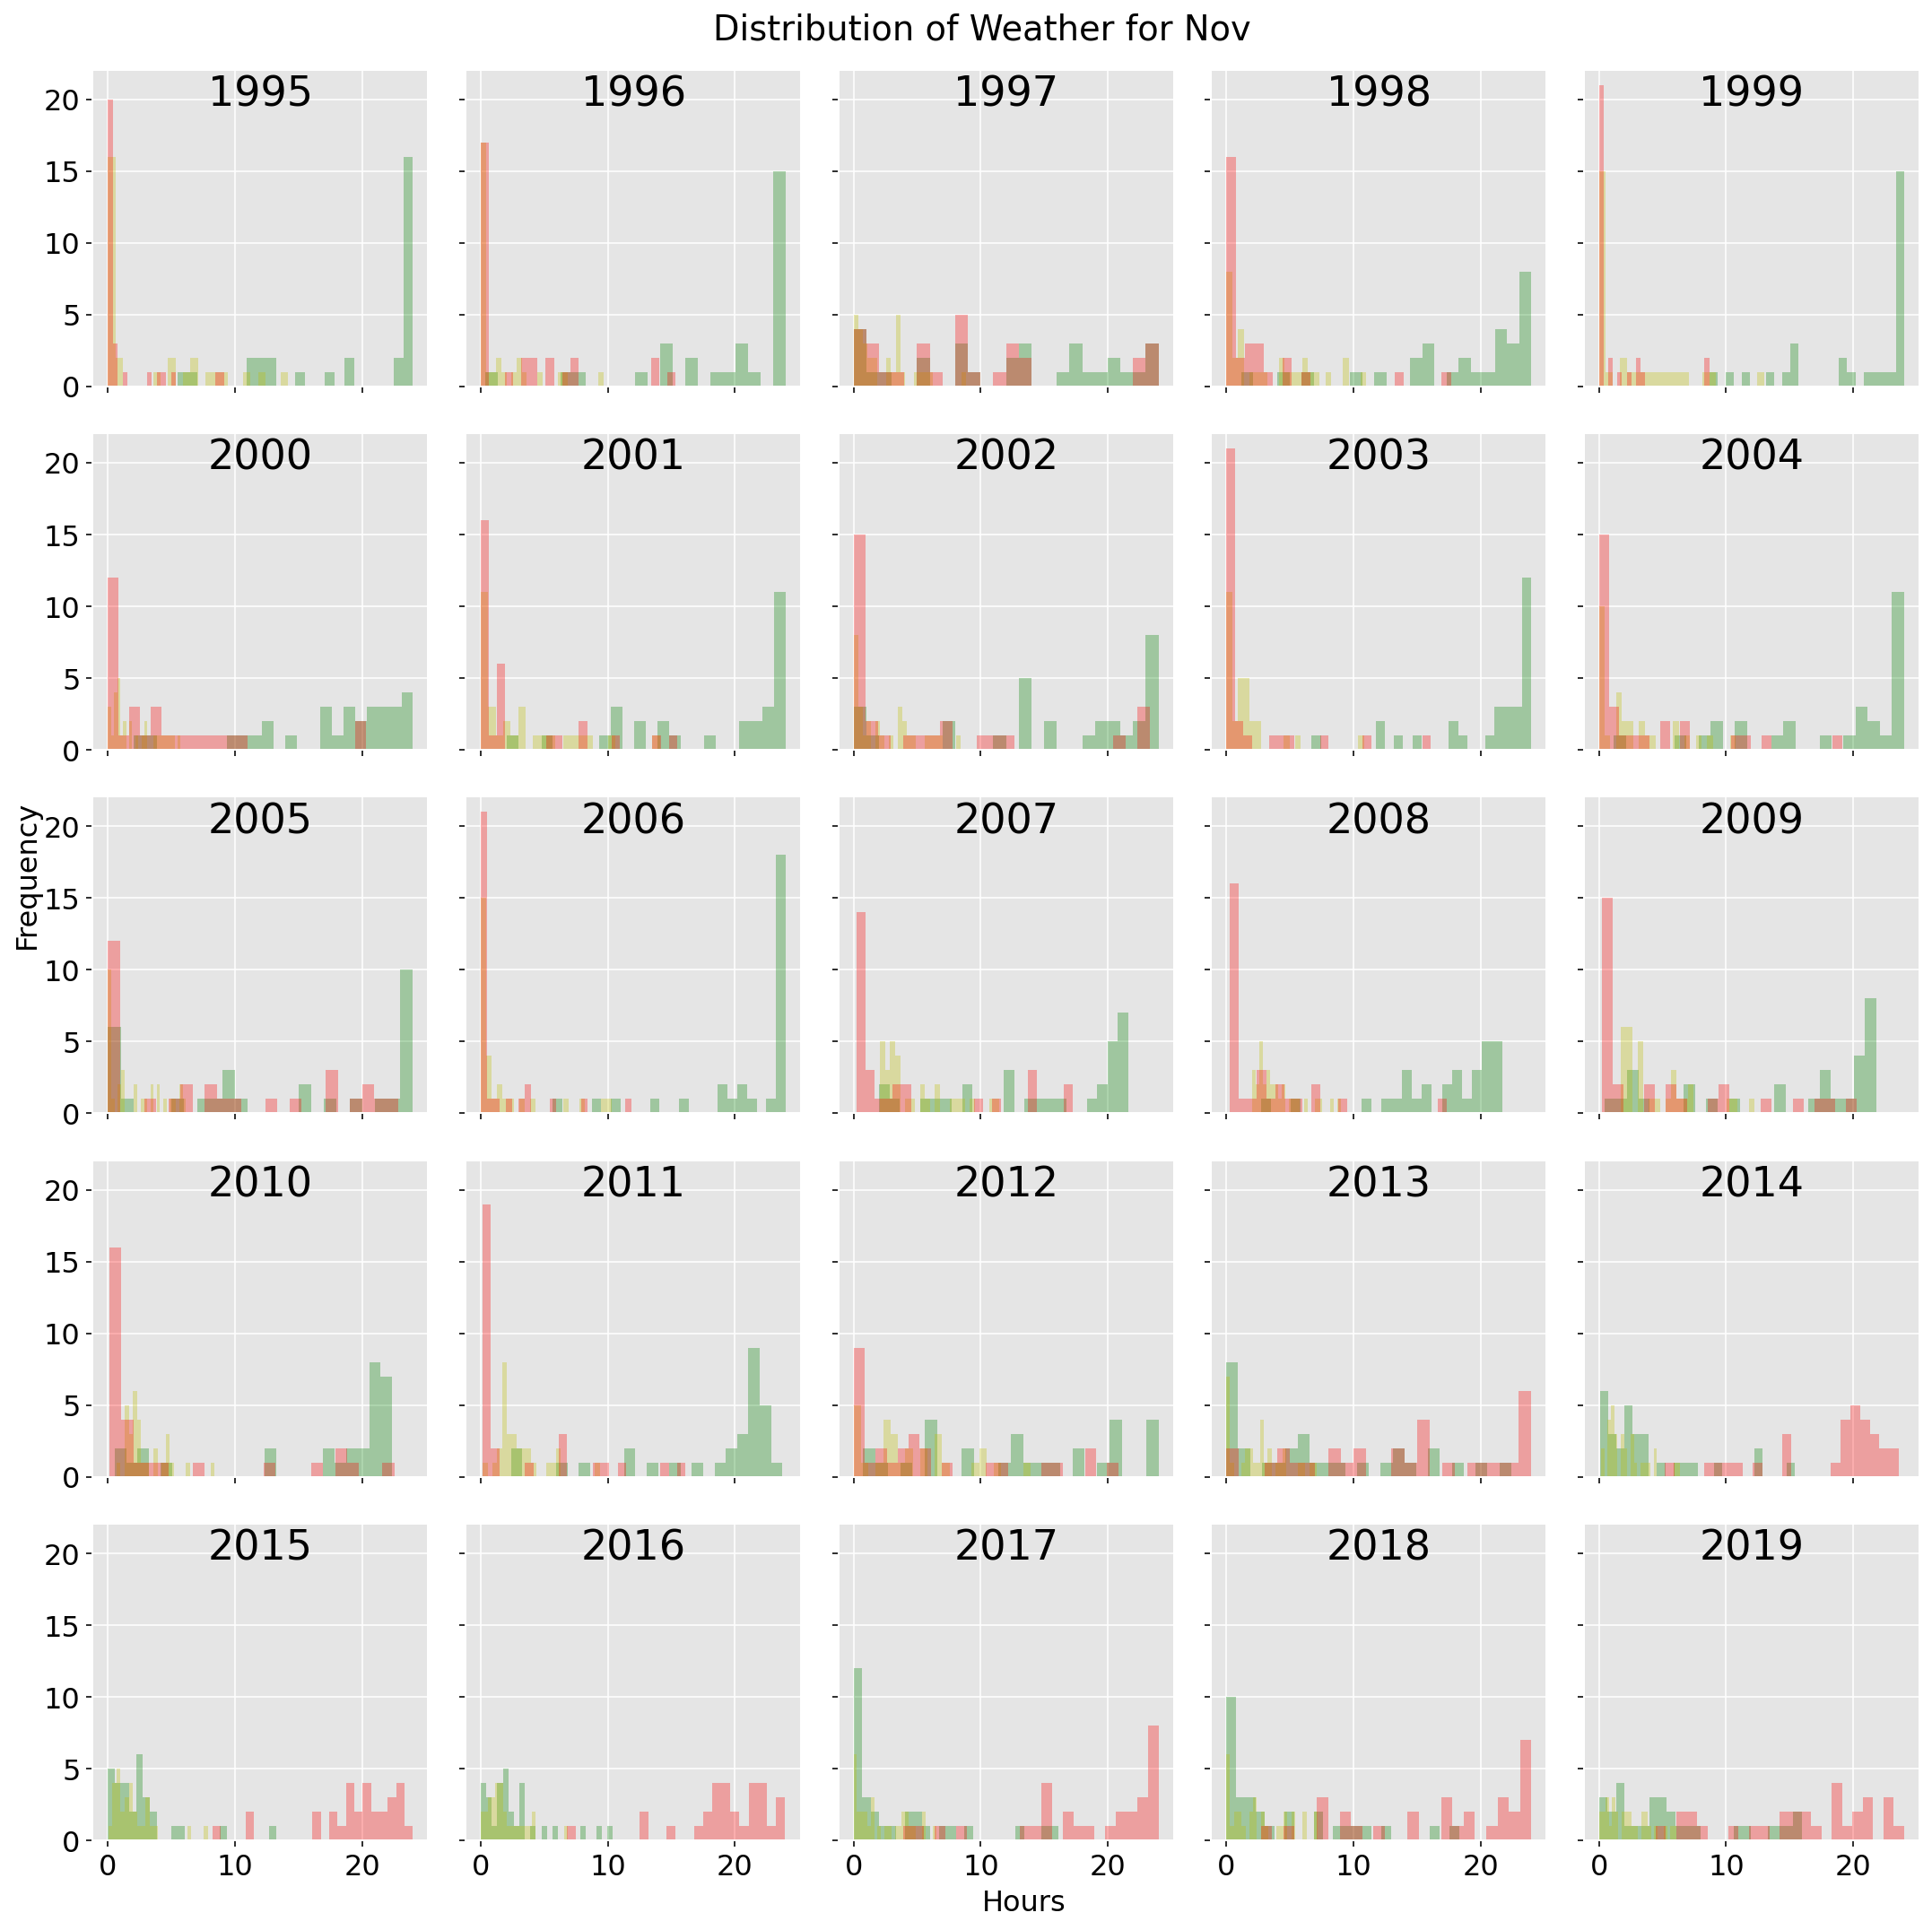

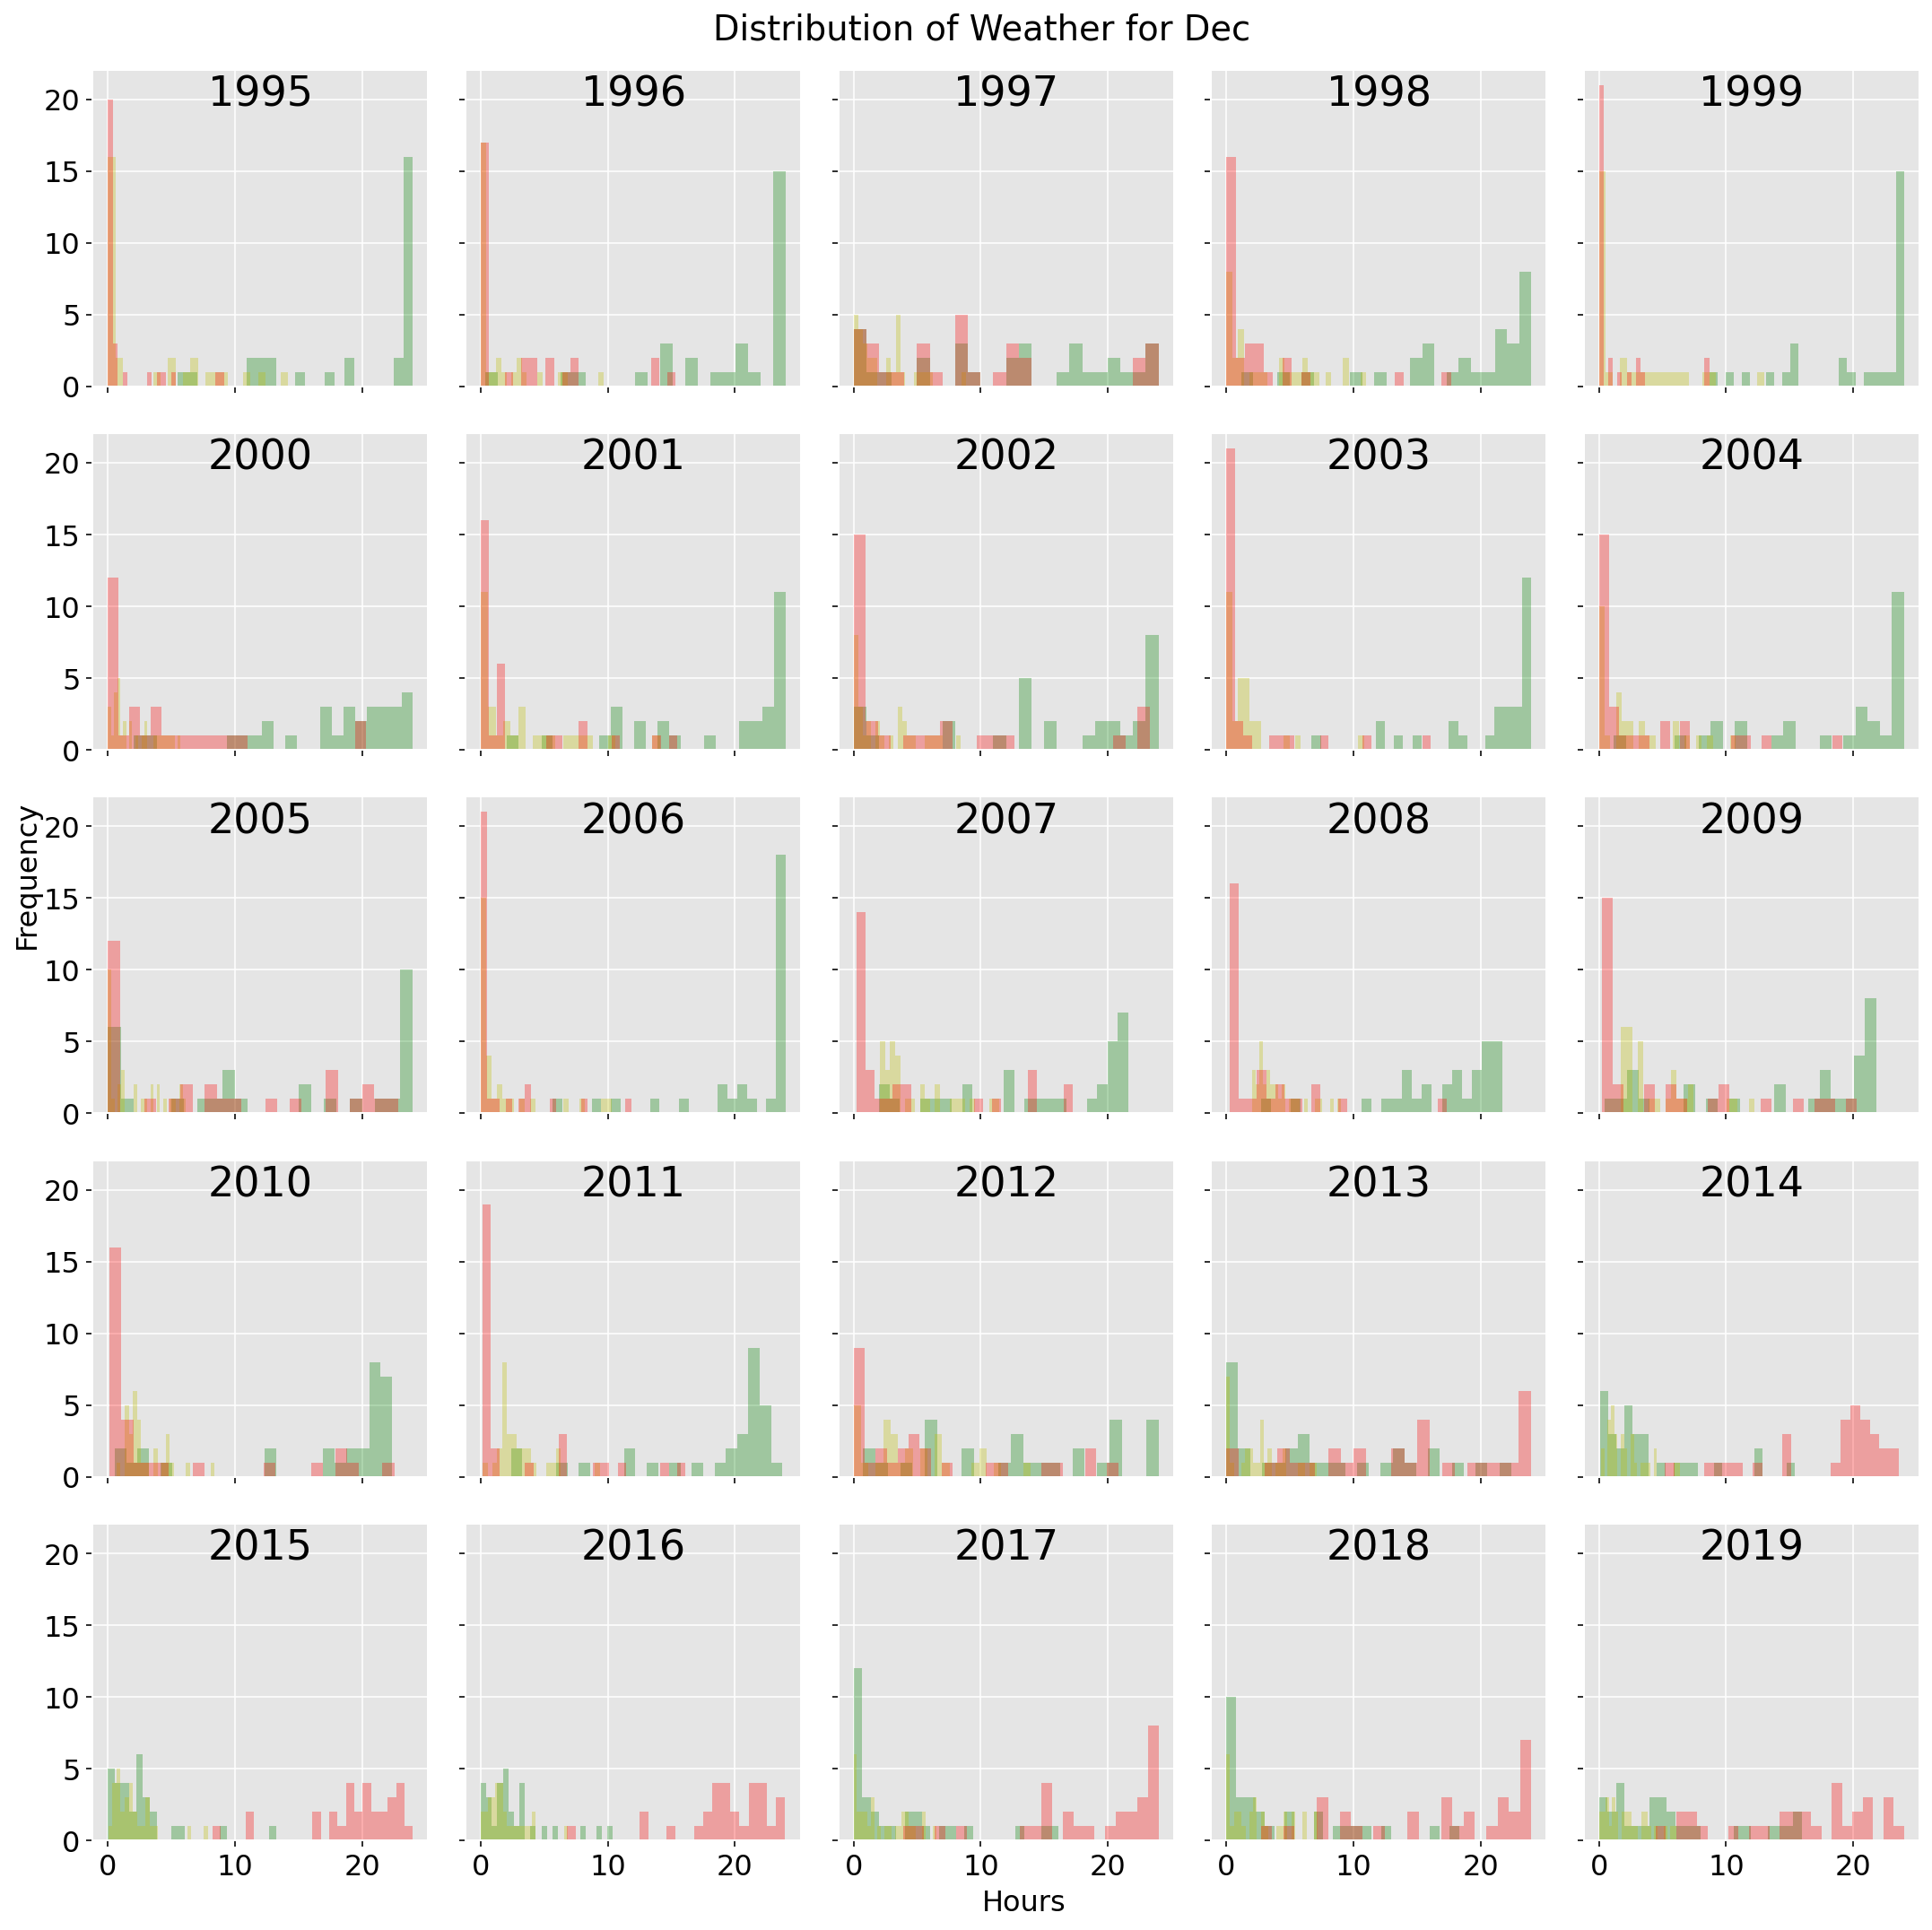

In [ ]:
yrs = list(range(1995,2020,1))


for month in months:
    fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
    for i,ax in enumerate(axs.flatten()):
        df[(df['month']=='Jun') & (df['year']==yrs[i])].hist('Green',ax=ax,color='g',bins=24, alpha=0.3)
        df[(df['month']=='Jun') & (df['year']==yrs[i])].hist('Yellow',ax=ax,color='y',bins=24, alpha=0.3)
        df[(df['month']=='Jun') & (df['year']==yrs[i])].hist('Red',ax=ax,color='r',bins=24, alpha=0.3)
        ax.set_title(f'{yrs[i]}',y=1,pad=-20)
    fig.suptitle(f'Distribution of Weather for {month}')
    fig.text(.5,0,'Hours')
    fig.text(0,0.5,'Frequency',rotation='vertical')
    fig.tight_layout();


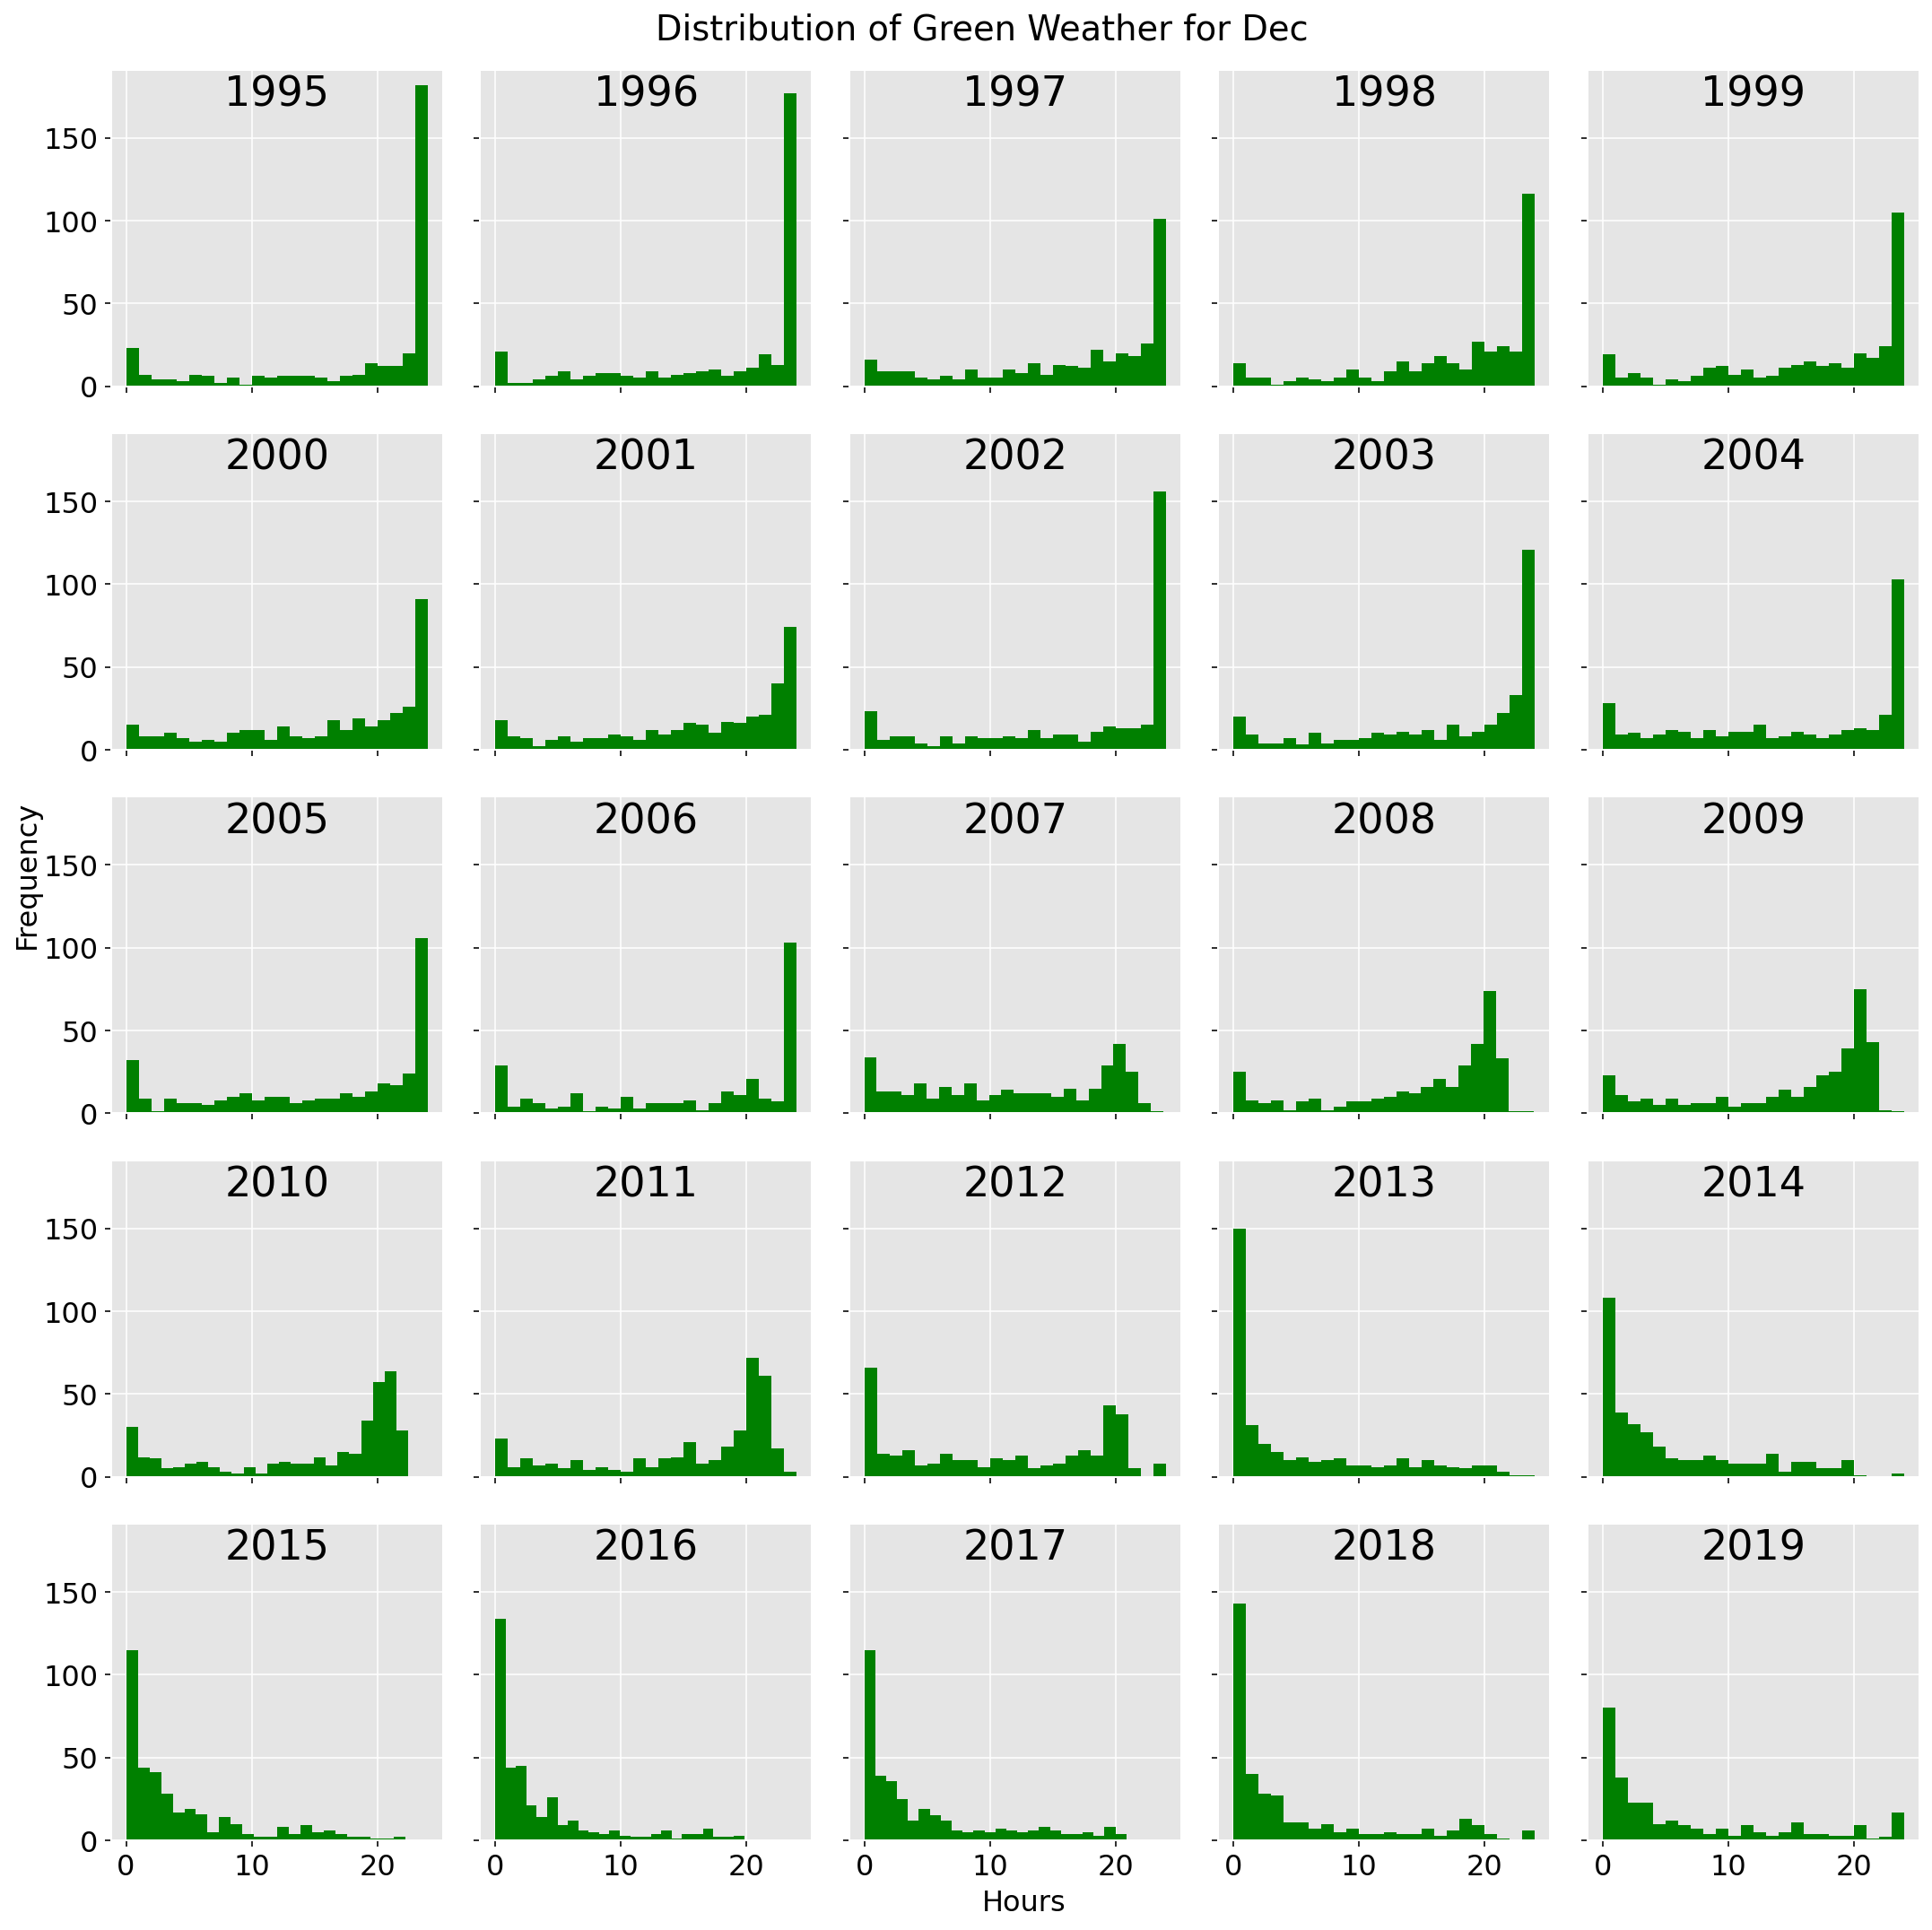

In [133]:
fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
for i,ax in enumerate(axs.flatten()):
    df[(df['year']==yrs[i])].hist('Green',ax=ax,color='g',bins=24, alpha=1)
    ax.set_title(f'{yrs[i]}',y=1,pad=-20)
fig.suptitle(f'Distribution of Green Weather for {month}')
fig.text(.5,0,'Hours')
fig.text(0,0.5,'Frequency',rotation='vertical')
fig.tight_layout();


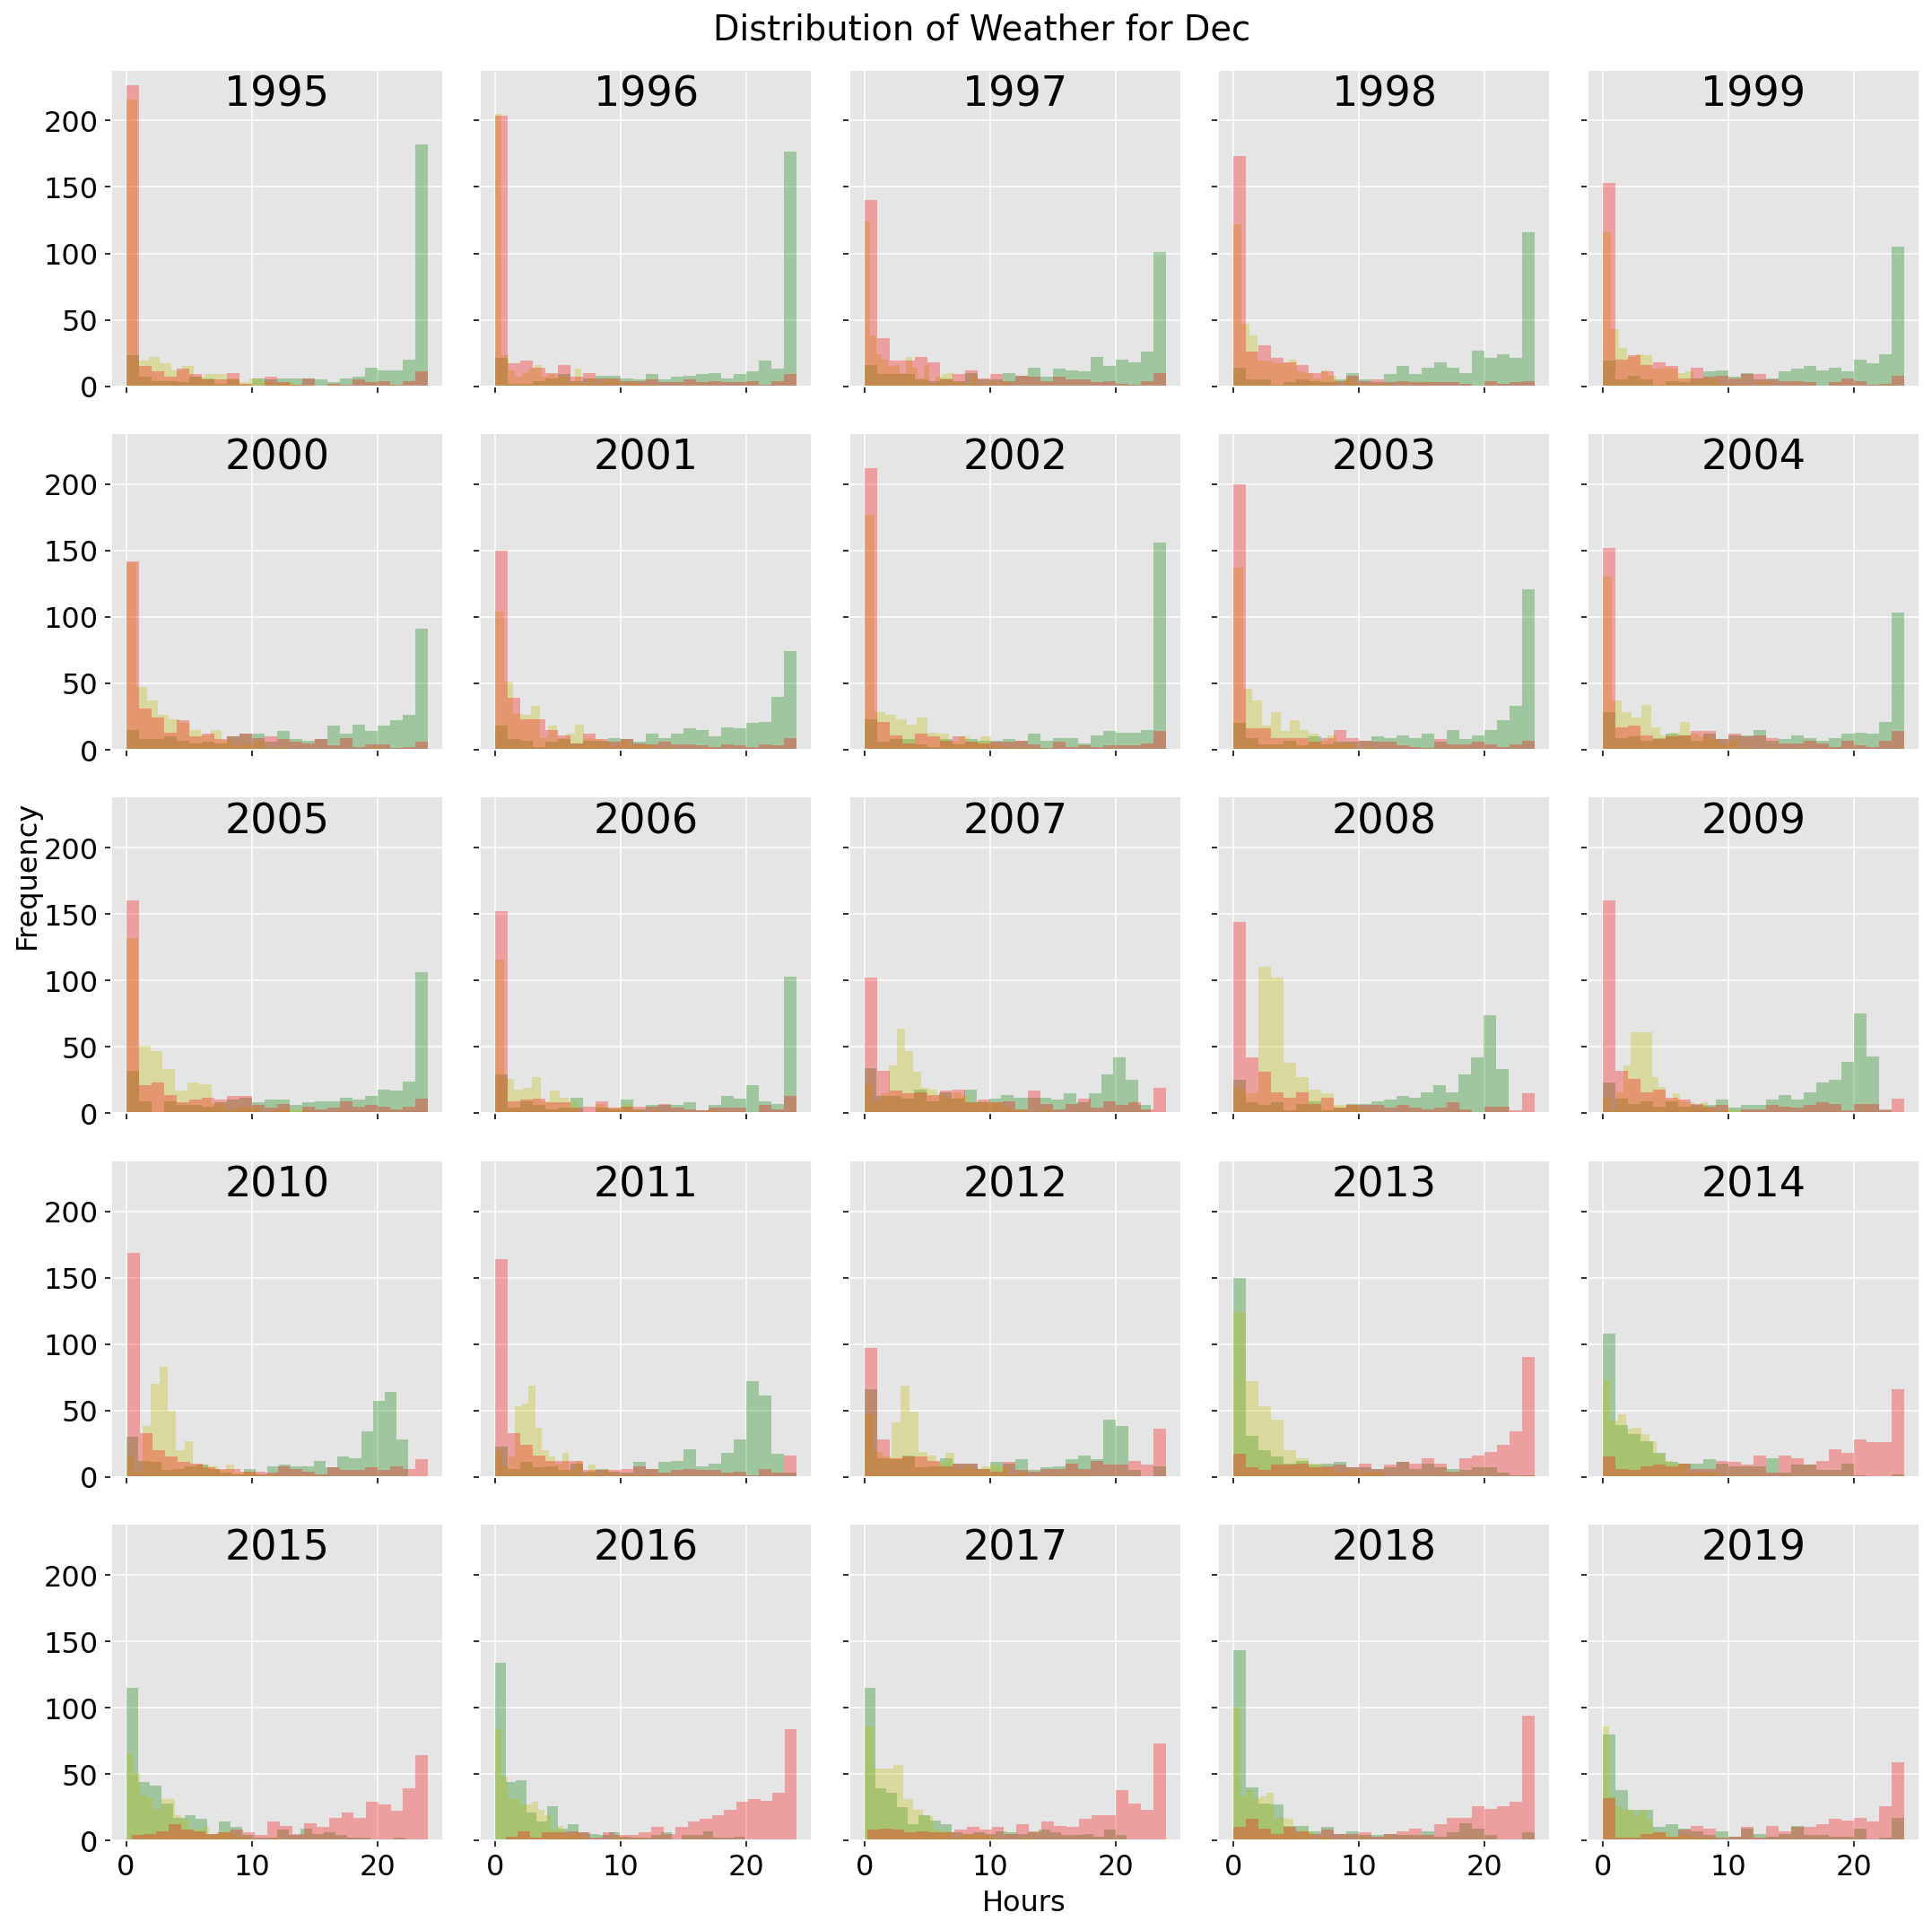

In [132]:
fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
for i,ax in enumerate(axs.flatten()):
    df[(df['year']==yrs[i])].hist('Green',ax=ax,color='g',bins=24, alpha=0.3)
    df[(df['year']==yrs[i])].hist('Yellow',ax=ax,color='y',bins=24, alpha=0.3)
    df[(df['year']==yrs[i])].hist('Red',ax=ax,color='r',bins=24, alpha=0.3)
    ax.set_title(f'{yrs[i]}',y=1,pad=-20)
fig.suptitle(f'Distribution of Weather for {month}')
fig.text(.5,0,'Hours')
fig.text(0,0.5,'Frequency',rotation='vertical')
fig.tight_layout();
